In [1]:
import sys
sys.path.append('C:\Anaconda3\Lib\site-packages')

import json
import numpy as np
import datetime as dt
import glob
import os
import pandas as pd

# For loading tweets to generators
from itertools import chain

# For counting number of instances
from collections import Counter

# To show loop progress
from tqdm import *

% matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

### Read tweets into pandas dataframe
The name of the game here will be to load tweets with minimum memory usage. My plan is to store the tweets (saved in .json format) in a generator. Then iterate through the object and only store desired information from the tweet. I want to store the following:

- text
- date created
- retweet or original
- user
- number of likes
- number of retweets
- number of user followers
- number of user following

#### Analysis outlook

It might be interesting to try and predict things like number of likes based on the last three features. By converting the number of likes into catagories e.g. none (0), low (1-5), moderate(6-15), high(16-100), famous(100+) we are open to a range of machine learning algorithms such as kNN, binary search tree, OvR (one vs. rest) linear models e.g. linear regression and logistic regression. Should choose categories such that each is well represented.

It occurs to me that I should be collecting tweets after at least a couple days so they can collect likes and retweets. I did this for the most part but not as a rule.

#### Read tweets the lazy way with large memory cost

In [2]:
# # Use glob to search through all dates with specific hashtag
# # then read the files and load the cumulitive result into a
# # list to return

# def merge_tweets(file_root, skip=100):
#     ''' Function that compiles tweets from multiple files
#         into a single list.  This may take a while.
        
#         file_root - Root directory to folder
#         skip (int) - Number of files to skip over before storing
#                      a tweet to memory.
#         '''
#     print(list(glob.iglob(file_root+'*')))
#     tweet_files = list(glob.iglob(file_root+'*'))
#     tweets = []
#     for file in tweet_files:
#         with open(file, 'r') as f:
#             for i, line in enumerate(f.readlines()):
#                     if i%skip == 0:
#                         tweets.append(json.loads(line))
#         print('finished importing file:', file)
#     return tweets
#
# data = merge_tweets(file_root='#nhl/', skip=100)

In [3]:
# Use glob to search through all dates with specific hashtag
# then read the files and load the cumulitive result into generator

def merge_tweets(file_root, skip, file_start=''):
    ''' Function that compiles tweets from multiple files
        into a single list.  This may take a while.
        
        file_root (str) - Root directory to folder
        skip (int)      - To save memory, skip over
                          files using the rule:
                          if i%skip == 0. e.g. skip=1
                          reads in all tweets because
                          i%1 == 0 for all integers i. '''
    
    if not file_start:
        file_start = file_root
    file_root = file_root + '/' + file_start + '*'
    tweet_files = list(glob.iglob(file_root))
    tweets = iter(())
    for f in tqdm(tweet_files):
        t = load_tweets(f, skip)
        tweets = chain(tweets, t)
    return tweets

def load_tweets(file, skip):
    with open(file, 'r') as f:
        tweets = (json.loads(line) for i, line in enumerate(f.readlines()) if i%skip==0)
    return tweets

In [4]:
if True:
    # Put tweets into a dictionary
    all_tweets = {}

    # Input folder names
    search_phrases = ['#nhl',
                       'Pavelski', 'Lucic',
                       'Ovechkin', 'Giroux',
                       'Jagr', 'Tavares',
                       'Kucherov', 'Mrazek',
                       'Seguin', 'Pominville',
                       'Crosby', 'Lundqvist',
                       'Tarasenko', 'Kane',
                       'Perry', 'Forsberg']

    for folder in tqdm(search_phrases):
        all_tweets[folder] = merge_tweets(file_root=folder, skip=1)

    all_tweets

In [5]:
# ''' Test cell '''

# file_root = 'Kane'
# skip = 100
# file_start = ''

# if not file_start:
#     file_start = file_root
# file_root = file_root + '/' + file_start + '*'
# tweet_files = list(glob.iglob(file_root))

# for file in tqdm(tweet_files):
#     print(file)
#     with open(file, 'r') as f:
#         try:
#             tweets = (json.loads(line) for i, line in enumerate(f.readlines()) if i%skip==0)
#         except:
#             print(file, tweets)
#             break
# #         for i, line inenumerate(f.readlines()):
# #             if i%skip == 0:
# #                 try:
# #                     t = json.loads(line)
# #                     # print(t['text'])
# #                 except:
# #                     print('last imported line')
# #                     print(t)


In [6]:
# Iterate through tweets, check for NHL related
# phrases in tweet['text'] and save qualifying
# tweets to a new file

criteria = {'#nhl': ['nhl'],
            'Pavelski': ['NHL', 'nhl', 'hockey', 'Hockey',
                         'SJS', 'sjs', 'sharks', 'Sharks',
                         'jose', 'Jose', 'Joe'],
            'Lucic': ['NHL', 'nhl', 'hockey', 'Hockey',
                      'LAK', 'kings', 'Kings',
                      'angeles', 'Angeles', 'Milan'],
            'Ovechkin': ['NHL', 'nhl', 'hockey', 'Hockey',
                         'WSH', 'wsh', 'caps', 'Caps',
                         'capitals', 'Capitals',
                         'washington', 'Washington',
                         'Alex'],
            'Giroux': ['NHL', 'nhl', 'hockey', 'Hockey',
                       'PHI', 'phi', 'flyers', 'Flyers',
                       'Philadelphia', 'Claude'],
            'Jagr': ['NHL', 'nhl', 'hockey', 'Hockey',
                     'FLA', 'panthers', 'Panthers',
                     'florida', 'Florida', 'Jaromir'],
            'Tavares': ['NHL', 'nhl', 'hockey', 'Hockey',
                        'NYI', 'nyi', 'islanders', 'Islanders',
                        'york', 'York', 'John'],
            'Kucherov': ['NHL', 'nhl', 'hockey', 'Hockey',
                         'TBL', 'tbl', 'lightning', 'Lightning',
                         'tampa', 'Tampa', 'Nikita'],
            'Mrazek': ['NHL', 'nhl', 'hockey', 'Hockey',
                       'DET', 'det', 'Wings', 'wings',
                       'Detroit', 'Petr'],
            'Seguin': ['NHL', 'nhl', 'hockey', 'Hockey',
                       'DAL', 'dal', 'stars', 'Stars',
                       'Dallas', 'Tyler'],
            'Pominville': ['NHL', 'nhl', 'hockey', 'Hockey',
                           'MIN', 'min', 'wild', 'Wild',
                           'Minnesota', 'Jason'],
            'Crosby': ['NHL', 'nhl', 'hockey', 'Hockey',
                       'PIT', 'penguins', 'Penguins',
                       'Pittsburgh', 'Sidney'],
            'Lundqvist': ['NHL', 'nhl', 'hockey', 'Hockey',
                          'NYR', 'nyr', 'rangers', 'Rangers',
                          'york', 'York', 'Henrik'],
            'Tarasenko':['NHL', 'nhl', 'hockey', 'Hockey',
                         'STL', 'stl', 'blues', 'Blues',
                         'louis', 'Louis', 'Vladimir'],
            'Kane': ['NHL', 'nhl', 'hockey', 'Hockey',
                     'CHI', 'chi', 'hawks', 'Hawks',
                     'chicago', 'Chicago', 'Patrick'],
            'Perry': ['NHL', 'nhl', 'hockey', 'Hockey',
                      'ducks', 'Ducks', 'Corey'],
            'Forsberg': ['NHL', 'nhl', 'hockey', 'Hockey',
                         'NSH', 'nsh', 'predators', 'Predators',
                         'Nashville', 'Filip']}

if True:
    for folder in tqdm(all_tweets.keys()):
        with open(folder+'/filtered_tweets.json', 'w') as f:
            for t in all_tweets[folder]:
                for word in criteria[folder]:
                    if word in t['text']:
                        json.dump(t, f)
                        f.write('\n')
                        break

In [7]:
# Read in filtered tweets

if True:
    
    # Put tweets into a dictionary
    all_tweets = {}
    
    # Input folder names
    search_phrases = ['#nhl',
                       'Pavelski', 'Lucic',
                       'Ovechkin', 'Giroux',
                       'Jagr', 'Tavares',
                       'Kucherov', 'Mrazek',
                       'Seguin', 'Pominville',
                       'Crosby', 'Lundqvist',
                       'Tarasenko', 'Kane',
                       'Perry', 'Forsberg']

    for folder in tqdm(search_phrases):
        all_tweets[folder] = merge_tweets(file_root=folder, skip=1,
                                          file_start='filtered_tweets')

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [01:26<00:00,  6.09s/it]


In [8]:
# Iterate over generators containing tweets and
# append desired information to lists

data = {'search_phrase': [], 'text': [], 'screen_name': [], 'created_at': [],
        'retweet_count': [], 'favorite_count': [],
        'friends_count': [], 'followers_count': []}

for folder in tqdm(all_tweets.keys()):
    for t in all_tweets[folder]:
        data['search_phrase'].append(folder)
        data['text'].append(t['text'])
        data['screen_name'].append(t['user']['screen_name'])
        data['created_at'].append(t['created_at'])
        data['retweet_count'].append(t['retweet_count'])
        data['favorite_count'].append(t['favorite_count'])
        data['friends_count'].append(t['user']['friends_count'])
        data['followers_count'].append(t['user']['followers_count'])


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [01:15<00:00,  3.38s/it]


In [9]:
# Create pandas dataframe from dictionary

df = pd.DataFrame(data)

In [ ]:
# Drop duplicate entries that may exist

df.drop_duplicates(inplace=True)

In [10]:
# Add column for retweet or original
RT = []
for t in df.text:
    RT.append(t.split()[0]=='RT')
df['RT'] = RT

# Convert created_at to datetimes
df['created_at'] = pd.to_datetime(df['created_at'])

df.head()

created_at  favorite_count  followers_count  friends_count  \
0 2016-05-18 23:59:19               0              499            356   
1 2016-05-18 23:59:17               5             6381            646   
2 2016-05-18 23:59:03               0              453            439   
3 2016-05-18 23:58:48               0              433            477   
4 2016-05-18 23:58:36               0               20            137   

   retweet_count      screen_name search_phrase  \
0             79     puckmehard93        Crosby   
1              2       BWest_Trib        Crosby   
2            798       GMONEY__11        Crosby   
3            664  Kristina_Streno        Crosby   
4              0         t4tuck61        Crosby   

                                                text     RT  
0  RT @SHOsports: Before #PITvsTBL, go behind-the...   True  
1  OK, 1 more bit about Kunitz. I got a few ?'s a...  False  
2  RT @EvgeniMaIkinEgo: Active NHL Players Averag...   True  
3  RT @HkyNightPunjabi: You asked for it, we deli...   True  
4  @NHLTonight how's Crosby the best # doesn't ki...  False

In [11]:
df.dtypes

created_at         datetime64[ns]
favorite_count              int64
followers_count             int64
friends_count               int64
retweet_count               int64
screen_name                object
search_phrase              object
text                       object
RT                           bool
dtype: object

In [12]:
df.describe()

favorite_count  followers_count   friends_count   retweet_count  \
count  1108762.000000   1108762.000000  1108762.000000  1108762.000000   
mean         0.950873      5481.467392      843.319250      318.486397   
std         22.512844    207297.232402     3900.397764     1001.733345   
min          0.000000         0.000000        0.000000        0.000000   
25%          0.000000       101.000000      145.000000        0.000000   
50%          0.000000       292.000000      334.000000        8.000000   
75%          0.000000       678.000000      755.000000      193.000000   
max       5522.000000  38683845.000000   505524.000000   156304.000000   

             RT  
count   1108762  
mean   0.590858  
std    0.491676  
min       False  
25%           0  
50%           1  
75%           1  
max        True

### Test cells for searching dataframe

In [13]:
df2 = df.copy()

In [14]:
df2[(df.favorite_count > 50)|(df.retweet_count > 50)&(df.friends_count < 100)].head()

created_at  favorite_count  followers_count  friends_count  \
32  2016-05-18 23:51:50               0               92             80   
47  2016-05-18 23:49:14               0               77             13   
97  2016-05-18 23:40:54               0               50             46   
111 2016-05-18 23:39:29              90          1389481             47   
112 2016-05-18 23:39:29              90          1389481             47   

     retweet_count      screen_name search_phrase  \
32              79           RedC35        Crosby   
47              79  SportsF39622331        Crosby   
97              64      Jen21759515        Crosby   
111             35    ESPNStatsInfo        Crosby   
112             35    ESPNStatsInfo        Crosby   

                                                  text     RT  
32   RT @SHOsports: Before #PITvsTBL, go behind-the...   True  
47   RT @SHOsports: Before #PITvsTBL, go behind-the...   True  
97   RT @NHL: "He was good holding everyone account...   True  
111  Penguins: 4-0 this postseason when Sidney Cros...  False  
112  Penguins: 4-0 this postseason when Sidney Cros...  False

### Histograms of tweets during the playoffs

In [15]:
# Get our color palettes
import seaborn.apionly as sns

colors_1 = sns.diverging_palette(10, 250, l=60, n=16, center='dark')
sns.palplot(sns.diverging_palette(10, 250, l=60, n=16, center='dark'))
east_team_map =  ['#0161AB', '#E51837', '#F4793E', '#C51230',
                  '#F57D31', '#002147', '#000000', '#C5B358']
west_team_map =   ['#000000', '#C51230', '#F57D31', '#C60C30',
                   '#016F4A', '#FDBB30', '#00529C', '#007889']
colors_dict = {'Lundqvist': east_team_map[0],
               'Mrazek': east_team_map[1],
               'Giroux': east_team_map[2],
               'Jagr': east_team_map[3],
               'Tavares': east_team_map[4],
               'Ovechkin': east_team_map[5],
               'Kucherov': east_team_map[6],
               'Crosby': east_team_map[7],
               'Lucic': west_team_map[0],
               'Pominville': west_team_map[1],
               'Perry': west_team_map[2],
               'Kane': west_team_map[3],
               'Seguin': west_team_map[4],
               'Forsberg': west_team_map[5],
               'Tarasenko': west_team_map[6],
               'Pavelski': west_team_map[7]}

In [16]:
np.unique(df.search_phrase)

array(['#nhl', 'Crosby', 'Forsberg', 'Giroux', 'Jagr', 'Kane', 'Kucherov',
       'Lucic', 'Lundqvist', 'Mrazek', 'Ovechkin', 'Pavelski', 'Perry',
       'Pominville', 'Seguin', 'Tarasenko', 'Tavares'], dtype=object)

In [17]:
# Convert datetimes to timestamps for histograms

to_timestamp = np.vectorize(lambda x: x.timestamp())

time_stamps = {}
for name in tqdm(np.unique(df.search_phrase)):
    time_stamps[name] = to_timestamp(list(df[(df.search_phrase == name)].created_at))

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:08<00:00,  1.58it/s]


In [18]:
# Create numpy histograms

player_hist_bins = 100

my_hists, my_hist_times = {}, {}
for name in tqdm(np.unique(df.search_phrase)):
    my_hists[name] = np.histogram(time_stamps[name], bins=player_hist_bins)
    my_hist_times[name] = [dt.datetime.fromtimestamp(t) for t in my_hists[name][1][:-1]]

100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 1093.89it/s]


In [19]:
nhl_hist_bins = 70
my_hists['#nhl'] = np.histogram(time_stamps['#nhl'], bins=nhl_hist_bins)
my_hist_times['#nhl'] = [dt.datetime.fromtimestamp(t) for t in my_hists['#nhl'][1][:-1]]

delta = max(df.created_at)-min(df.created_at)
nhl_bin_width = (delta/nhl_hist_bins).days*24 + \
                (delta/nhl_hist_bins).seconds/60/60
print('NHL bin width: {} hours'.format(nhl_bin_width))

NHL bin width: 19.199166666666667 hours


#### Make each bar 24 hours - this will hold for the player plots as well

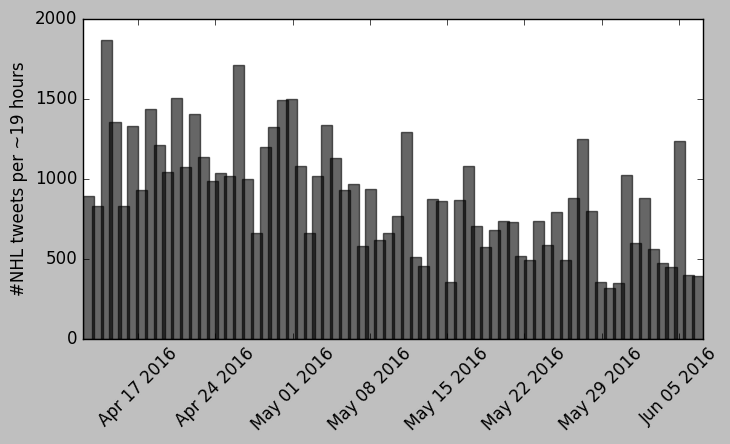

In [225]:
# with plt.xkcd():
fig = plt.figure(figsize=(8,4))
ax = plt.subplot(111)

ax.bar(my_hist_times['#nhl'], my_hists['#nhl'][0],
       color='black', lw=1, alpha=0.6, width=1)

tks = ax.xaxis.get_majorticklabels()
plt.setp(tks, rotation=45)

bar_width = df.created_at
ax.set_ylabel('#NHL tweets per ~{} hours'.format(int(nhl_bin_width)))

plt.savefig('figures/#nhl_hist.png', bbox_inches='tight', dpi=144)
plt.show()

In [21]:
all_players = ['Lundqvist', 'Mrazek', 'Giroux', 'Jagr',
               'Tavares', 'Ovechkin', 'Kucherov', 'Crosby',
               'Pavelski', 'Tarasenko', 'Forsberg', 'Seguin',
               'Kane', 'Perry', 'Pominville', 'Lucic']
east_players = all_players[:8]
west_players = all_players[8:][::-1]

In [22]:
east_players

['Lundqvist',
 'Mrazek',
 'Giroux',
 'Jagr',
 'Tavares',
 'Ovechkin',
 'Kucherov',
 'Crosby']

In [38]:
west_players

['Lucic',
 'Pominville',
 'Perry',
 'Kane',
 'Seguin',
 'Forsberg',
 'Tarasenko',
 'Pavelski']

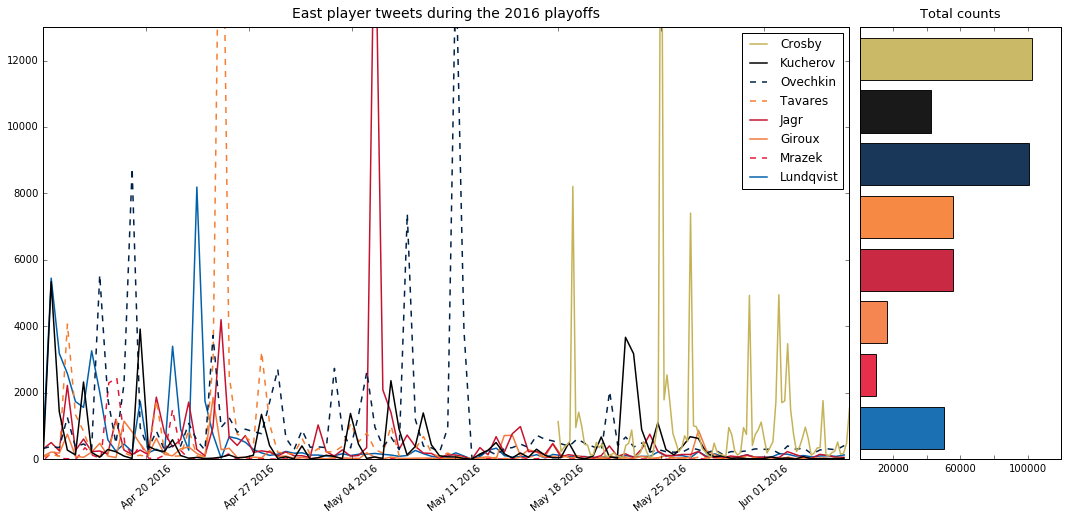

In [170]:
# with plt.xkcd():
if True:
    fig = plt.figure(figsize=(14,6))
    for i, player in enumerate(east_players):
        left, bottom, width, height = [0.0, 0.0, 0.8, 1.0]
        ax = fig.add_axes([left, bottom, width, height])
        if player == 'Mrazek' or player == 'Ovechkin' or player == 'Tavares':
            ax.plot(my_hist_times[player], my_hists[player][0],
                    label=player, linestyle='--',
                    color=colors_dict[player], linewidth=1.5)
        else:
            ax.plot(my_hist_times[player], my_hists[player][0],
                    label=player,
                    color=colors_dict[player], linewidth=1.5)
        ax.set_ylim(0, 13000)
        
        tks = ax.xaxis.get_majorticklabels()
        plt.setp(tks, rotation=40)
    
    h, l = ax.get_legend_handles_labels()
    ax.legend(h[::-1], l[::-1])
    ax.set_title('East player tweets during the 2016 playoffs', y=1.01, fontsize=14)
    
    left, bottom, width, height = [0.81, 0.0, 0.2, 1.0]
    ax_bar = fig.add_axes([left, bottom, width, height])
    ax_bar.barh(range(8), [sum(my_hists[p][0]) for p in east_players],
                color=[colors_dict[p] for p in east_players], alpha=0.9)
    ax_bar.set_yticks([])
    ax_bar.set_yticklabels([])
    ax_bar.set_ylim(-0.2, 8)
    ax_bar.set_title('Total counts', y=1.01, fontsize=13)
    for label in ax_bar.get_xticklabels()[::2]:
        label.set_visible(False)

    plt.savefig('figures/east_players.png', bbox_inches='tight', dpi=144)

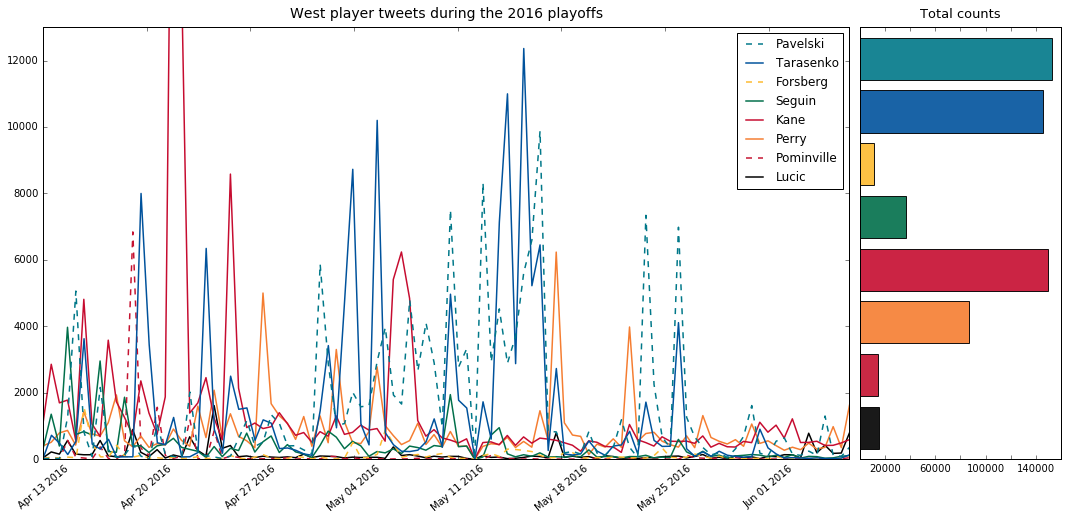

In [169]:
# with plt.xkcd():
if True:
    fig = plt.figure(figsize=(14,6))
    for i, player in enumerate(west_players):
        left, bottom, width, height = [0.0, 0.0, 0.8, 1.0]
        ax = fig.add_axes([left, bottom, width, height])
        if player == 'Pavelski' or player == 'Forsberg' or player == 'Pominville':
            ax.plot(my_hist_times[player], my_hists[player][0],
                    label=player, linestyle='--',
                    color=colors_dict[player], linewidth=1.5)
        else:
            ax.plot(my_hist_times[player], my_hists[player][0],
                    label=player,
                    color=colors_dict[player], linewidth=1.5)
        ax.set_ylim(0, 13000)
        
        tks = ax.xaxis.get_majorticklabels()
        plt.setp(tks, rotation=40)
    
    h, l = ax.get_legend_handles_labels()
    ax.legend(h[::-1], l[::-1])
    ax.set_title('West player tweets during the 2016 playoffs', y=1.01, fontsize=14)
    
    left, bottom, width, height = [0.81, 0.0, 0.2, 1.0]
    ax_bar = fig.add_axes([left, bottom, width, height])
    ax_bar.barh(range(8), [sum(my_hists[p][0]) for p in west_players],
                color=[colors_dict[p] for p in west_players], alpha=0.9)
    ax_bar.set_yticks([])
    ax_bar.set_yticklabels([])
    ax_bar.set_ylim(-0.2, 8)
    ax_bar.set_title('Total counts', y=1.01, fontsize=13)
    for label in ax_bar.get_xticklabels()[::2]:
        label.set_visible(False)
    
plt.savefig('figures/west_players.png', bbox_inches='tight', dpi=144)

#### Iterate through players and save a figure for each

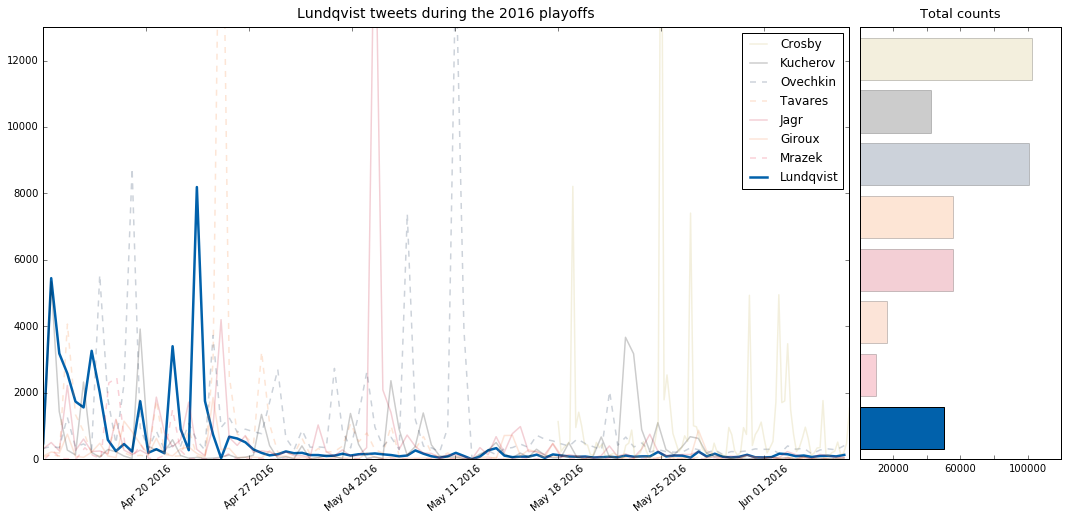

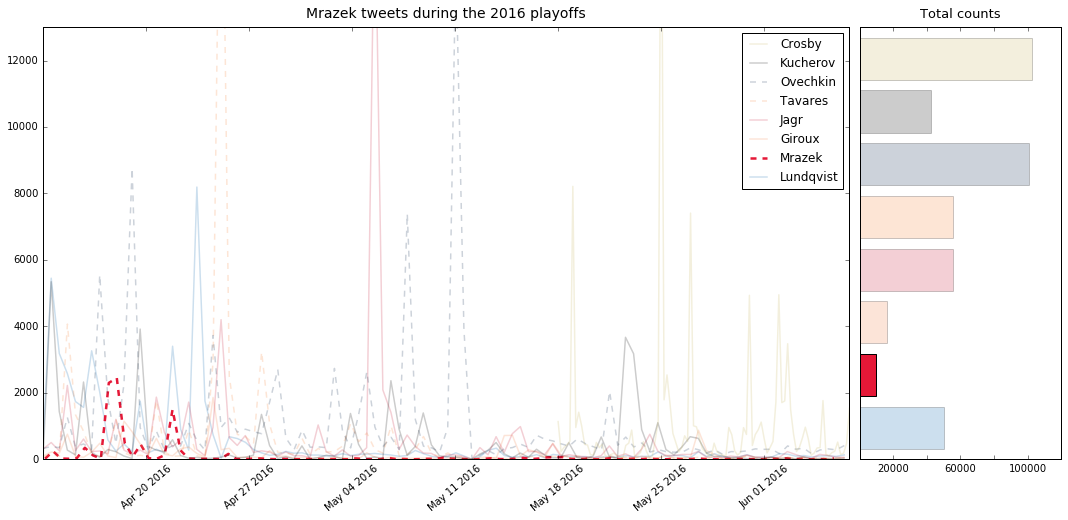

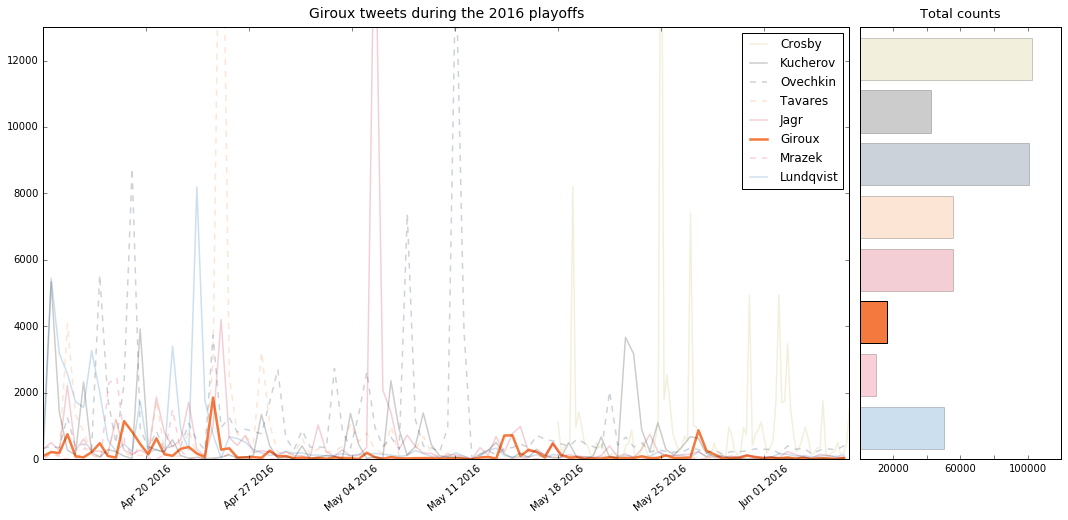

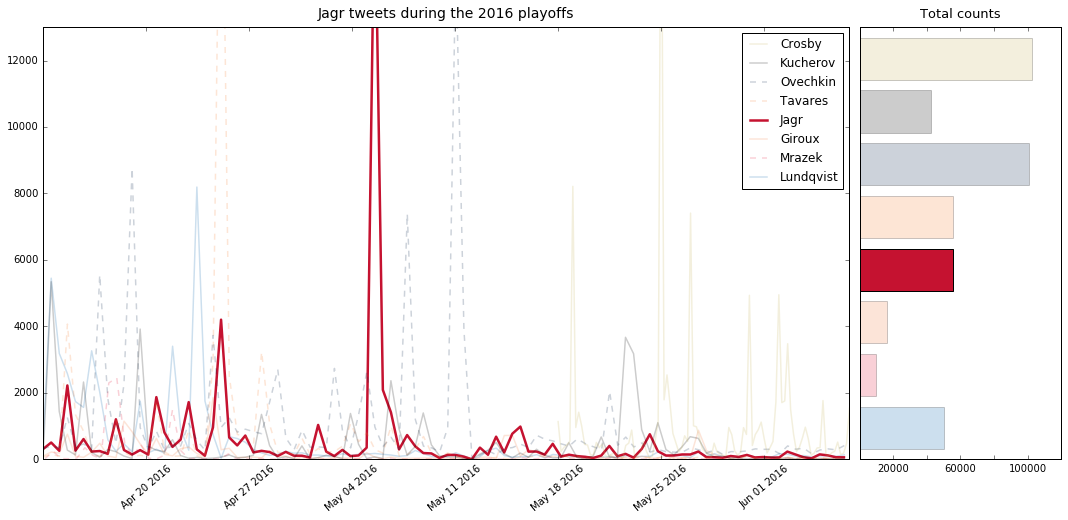

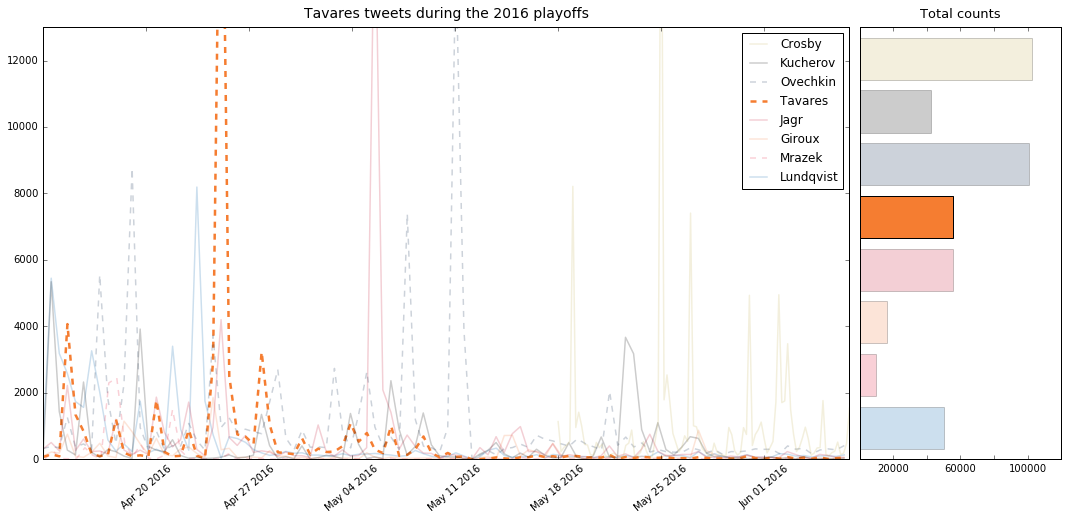

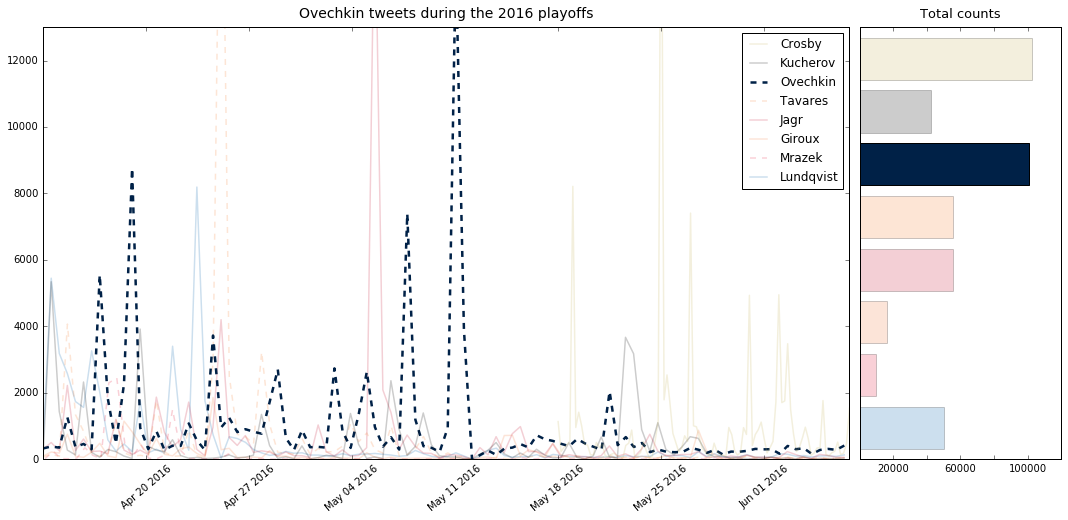

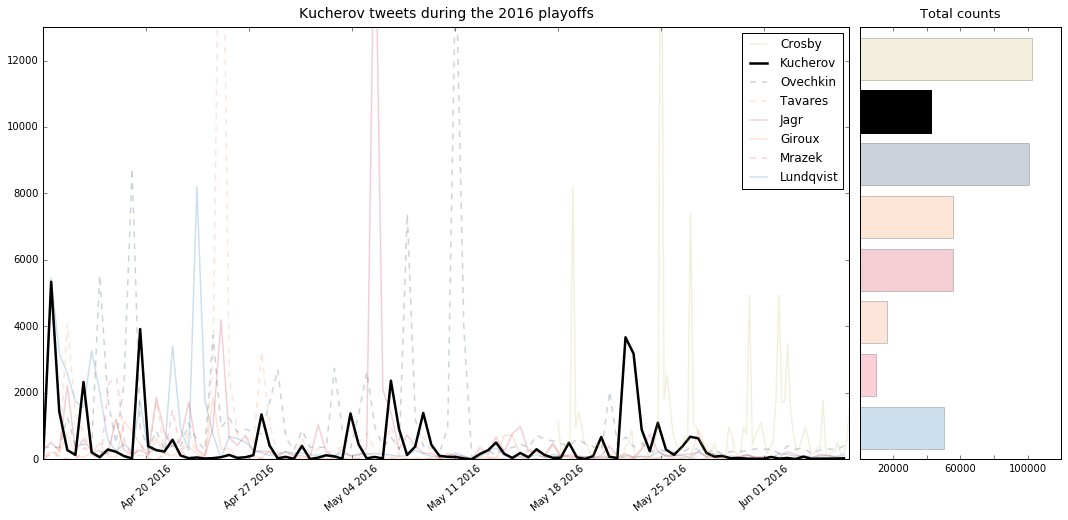

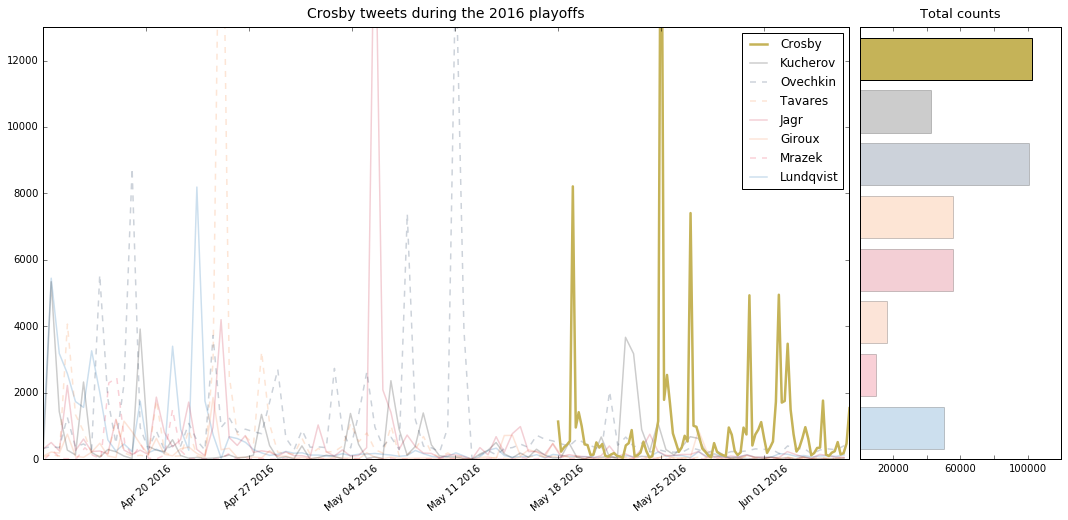

In [180]:
for ip, p in enumerate(east_players):
    fig = plt.figure(figsize=(14,6))
    for i, player in enumerate(east_players):
        left, bottom, width, height = [0.0, 0.0, 0.8, 1.0]
        ax = fig.add_axes([left, bottom, width, height])
        if p != player:
            if player == 'Mrazek' or player == 'Ovechkin' or player == 'Tavares':
                ax.plot(my_hist_times[player], my_hists[player][0],
                        label=player, linestyle='--', alpha=0.2,
                        color=colors_dict[player], linewidth=1.5)
            else:
                ax.plot(my_hist_times[player], my_hists[player][0],
                        label=player, alpha=0.2,
                        color=colors_dict[player], linewidth=1.5)
            ax.set_ylim(0, 13000)
            tks = ax.xaxis.get_majorticklabels()
            plt.setp(tks, rotation=40)
        else:
            if player == 'Mrazek' or player == 'Ovechkin' or player == 'Tavares':
                ax.plot(my_hist_times[p], my_hists[p][0],
                        color=colors_dict[p], linewidth=2.5,
                        label=p, linestyle='--')
            else:
                ax.plot(my_hist_times[p], my_hists[p][0],
                        color=colors_dict[p], linewidth=2.5,
                        label=p)
            ax.set_ylim(0, 13000)
            tks = ax.xaxis.get_majorticklabels()
            plt.setp(tks, rotation=40)

    
    h, l = ax.get_legend_handles_labels()
    ax.legend(h[::-1], l[::-1])
    ax.set_title(p+' tweets during the 2016 playoffs', y=1.01, fontsize=14)
    
    left, bottom, width, height = [0.81, 0.0, 0.2, 1.0]
    ax_bar = fig.add_axes([left, bottom, width, height])
    ax_bar.barh(range(8), [sum(my_hists[p][0]) for p in east_players],
                color=[colors_dict[p] for p in east_players], alpha=0.2)
    ax_bar.barh(ip, sum(my_hists[p][0]), color=colors_dict[p])
    ax_bar.set_yticks([])
    ax_bar.set_yticklabels([])
    ax_bar.set_ylim(-0.2, 8)
    ax_bar.set_title('Total counts', y=1.01, fontsize=13)
    for label in ax_bar.get_xticklabels()[::2]:
        label.set_visible(False)
        
    plt.savefig('figures/east_players/'+p+'.png', bbox_inches='tight', dpi=144)
        
    plt.show()

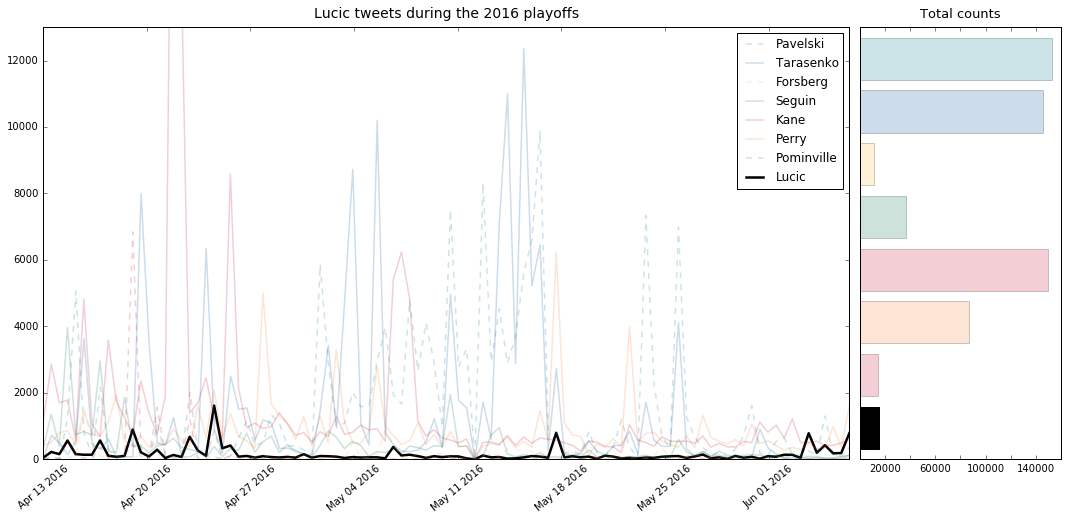

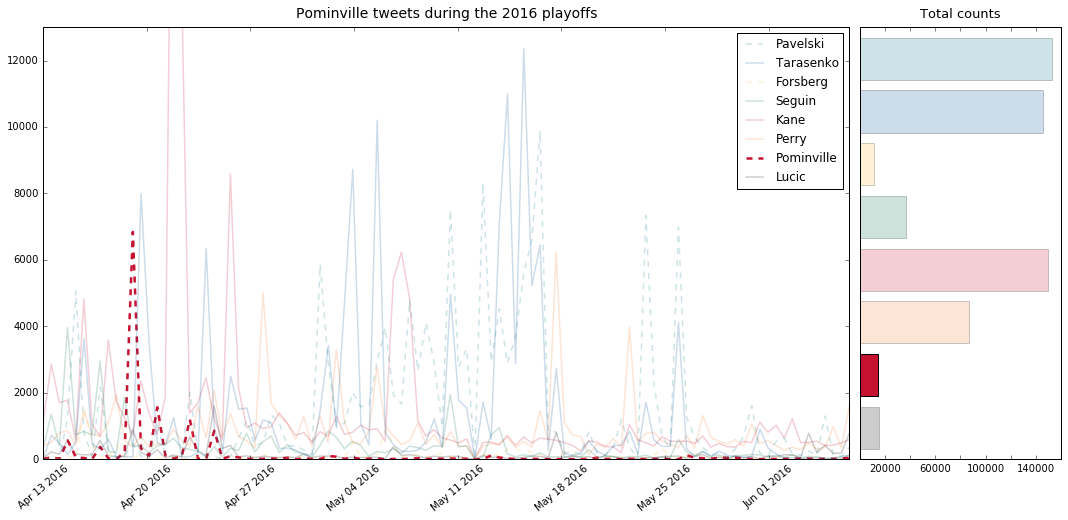

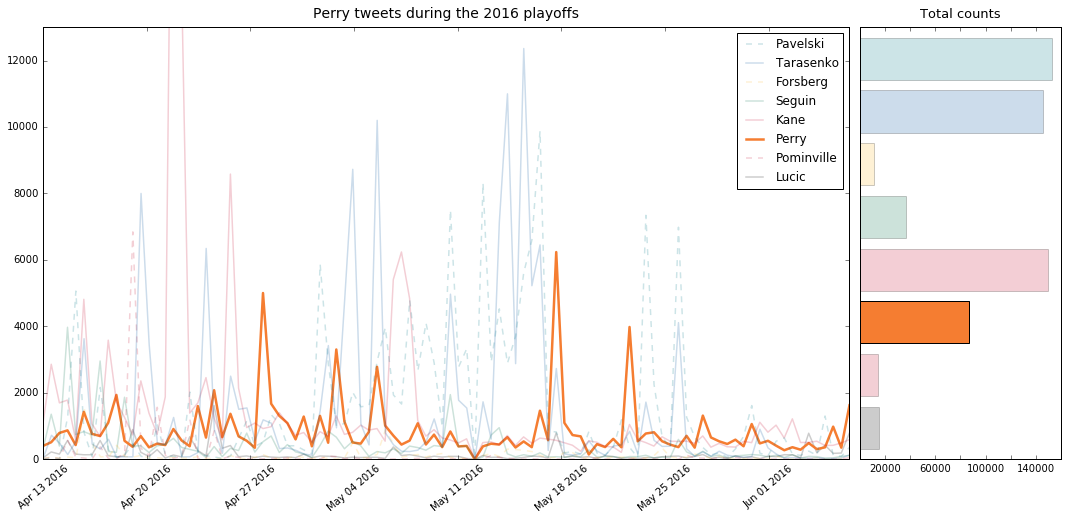

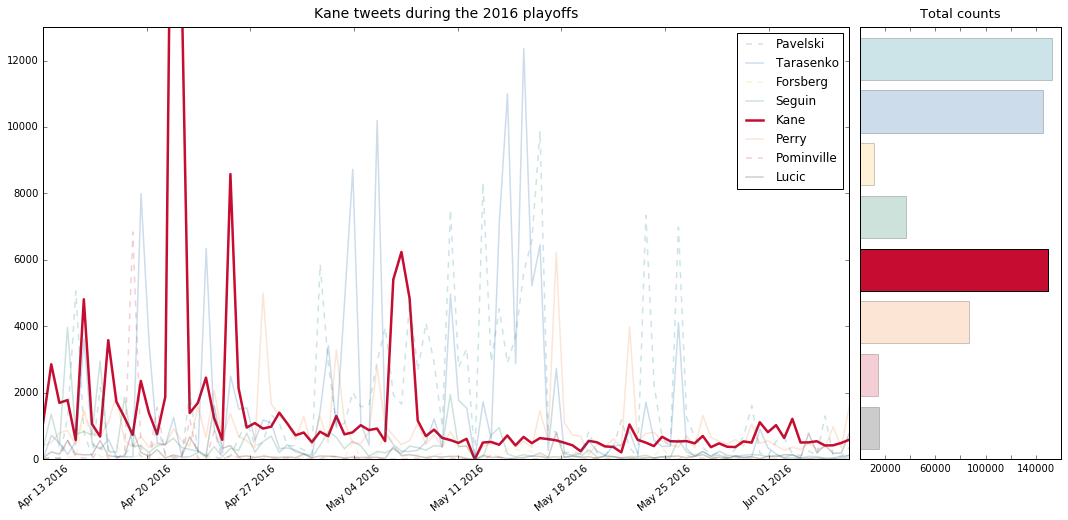

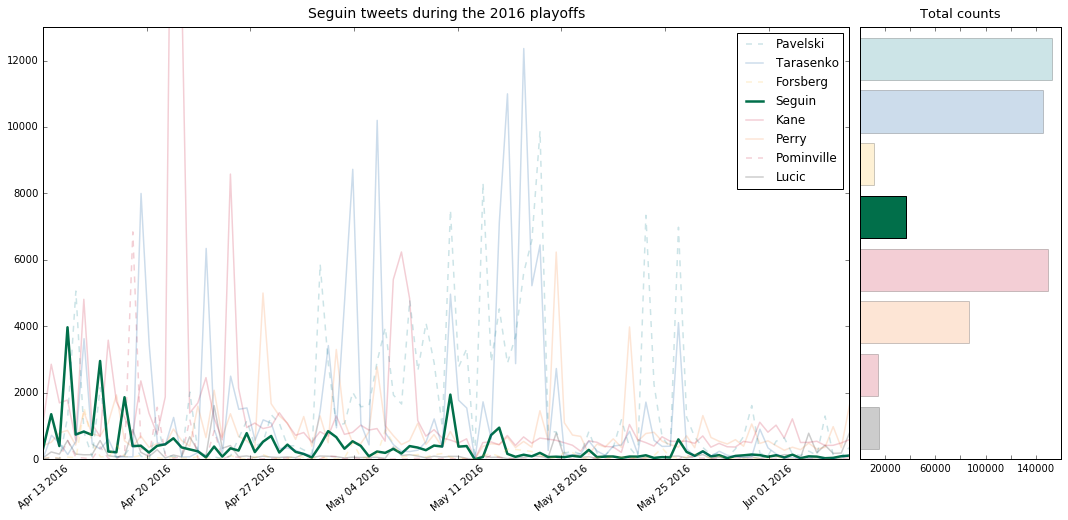

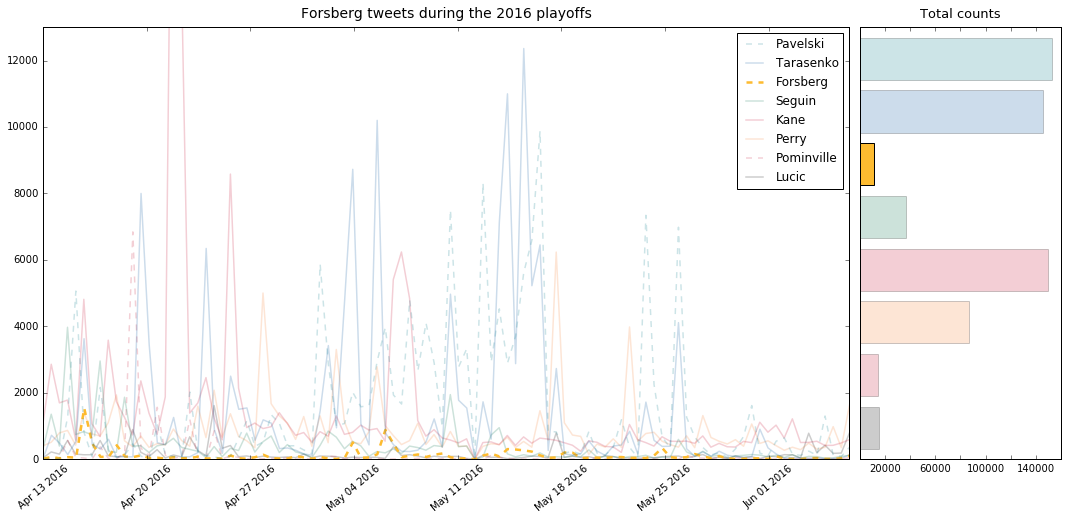

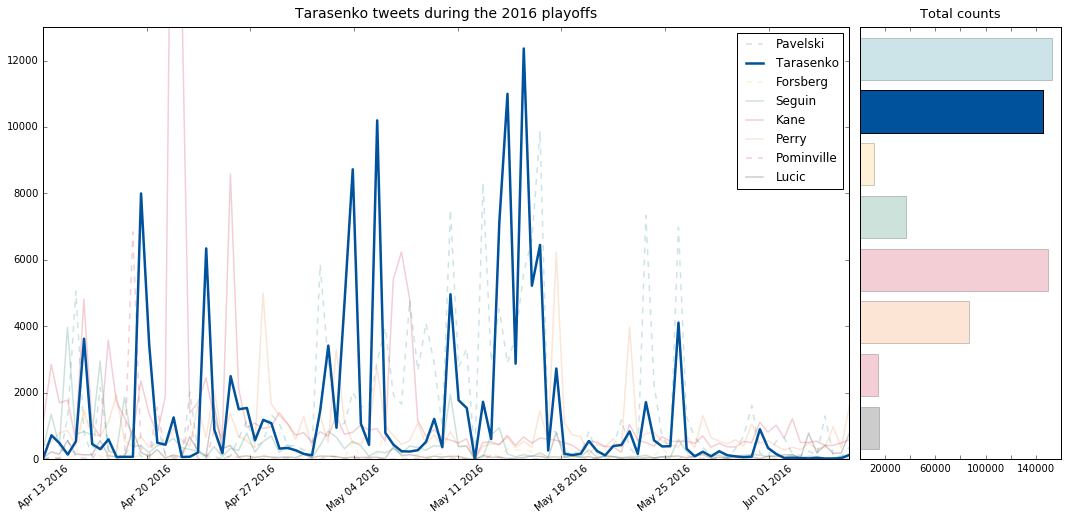

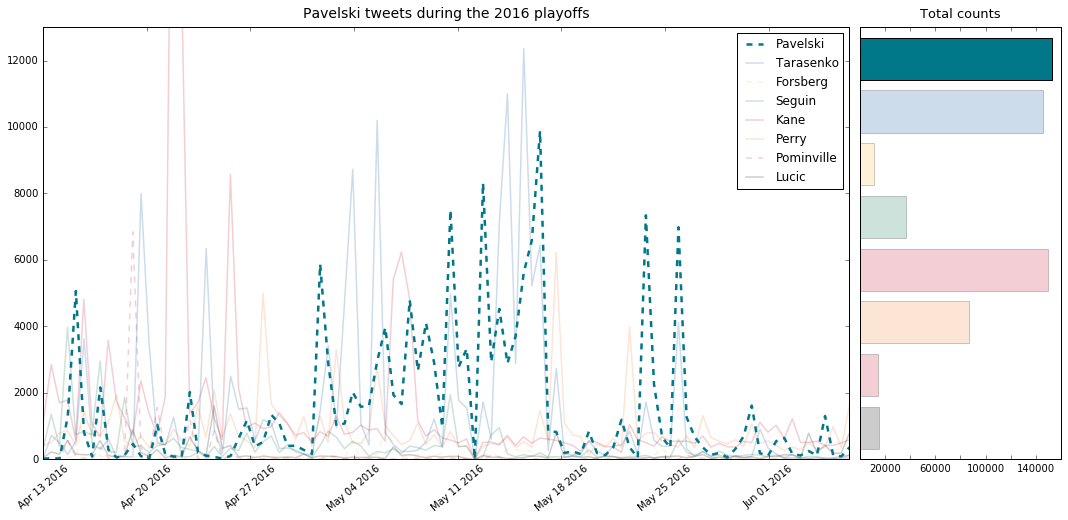

In [181]:
for ip, p in enumerate(west_players):
    fig = plt.figure(figsize=(14,6))
    for i, player in enumerate(west_players):
        left, bottom, width, height = [0.0, 0.0, 0.8, 1.0]
        ax = fig.add_axes([left, bottom, width, height])
        if p != player:
            if player == 'Pavelski' or player == 'Forsberg' or player == 'Pominville':
                ax.plot(my_hist_times[player], my_hists[player][0],
                        label=player, linestyle='--', alpha=0.2,
                        color=colors_dict[player], linewidth=1.5)
            else:
                ax.plot(my_hist_times[player], my_hists[player][0],
                        label=player, alpha=0.2,
                        color=colors_dict[player], linewidth=1.5)
            ax.set_ylim(0, 13000)
            tks = ax.xaxis.get_majorticklabels()
            plt.setp(tks, rotation=40)
        else:
            if player == 'Pavelski' or player == 'Forsberg' or player == 'Pominville':
                ax.plot(my_hist_times[p], my_hists[p][0],
                        color=colors_dict[p], linewidth=2.5,
                        label=p, linestyle='--')
            else:
                ax.plot(my_hist_times[p], my_hists[p][0],
                        color=colors_dict[p], linewidth=2.5,
                        label=p)
            ax.set_ylim(0, 13000)
            tks = ax.xaxis.get_majorticklabels()
            plt.setp(tks, rotation=40)

    
    h, l = ax.get_legend_handles_labels()
    ax.legend(h[::-1], l[::-1])
    ax.set_title(p+' tweets during the 2016 playoffs', y=1.01, fontsize=14)
    
    left, bottom, width, height = [0.81, 0.0, 0.2, 1.0]
    ax_bar = fig.add_axes([left, bottom, width, height])
    ax_bar.barh(range(8), [sum(my_hists[p][0]) for p in west_players],
                color=[colors_dict[p] for p in west_players], alpha=0.2)
    ax_bar.barh(ip, sum(my_hists[p][0]), color=colors_dict[p])
    ax_bar.set_yticks([])
    ax_bar.set_yticklabels([])
    ax_bar.set_ylim(-0.2, 8)
    ax_bar.set_title('Total counts', y=1.01, fontsize=13)
    for label in ax_bar.get_xticklabels()[::2]:
        label.set_visible(False)
        
    plt.savefig('figures/west_players/'+p+'.png', bbox_inches='tight', dpi=144)
        
    plt.show()

### Most influential twitter users
Determine influnce based on number of favorites + retweets on all original tweets. Also look at users who post the most and the highest post/(likes + retweets) ratio.

In [24]:
df_originals = df[(df.RT == False)]
df_originals.head()

created_at  favorite_count  followers_count  friends_count  \
1 2016-05-18 23:59:17               5             6381            646   
4 2016-05-18 23:58:36               0               20            137   
5 2016-05-18 23:58:09               2              403            306   
7 2016-05-18 23:57:50               1             3999            262   
8 2016-05-18 23:57:50               1             3999            262   

   retweet_count   screen_name search_phrase  \
1              2    BWest_Trib        Crosby   
4              0      t4tuck61        Crosby   
5              0  philip121212        Crosby   
7              0    Sportlogiq        Crosby   
8              0    Sportlogiq        Crosby   

                                                text     RT  
1  OK, 1 more bit about Kunitz. I got a few ?'s a...  False  
4  @NHLTonight how's Crosby the best # doesn't ki...  False  
5  @GreenFlyKnight1 @KANE_4_LIFE @killMOOSEkill @...  False  
7  ES scoring-chance leaders (last game):\n\nKill...  False  
8  ES scoring-chance leaders (last game):\n\nKill...  False

In [25]:
unique_names = np.unique(df_originals.screen_name)
all_users = {'influence': {user: 0 for user in unique_names},
             'count': dict(Counter(df_originals.screen_name))}

In [26]:
for user, L, R in zip(df_originals.screen_name,
                      df_originals.favorite_count,
                      df_originals.retweet_count):
    all_users['influence'][user] += (L + R)

In [27]:
all_users['ratio'] = {user: all_users['influence'][user]/all_users['count'][user] for user in unique_names}

In [27]:
# For sorting lists of tuples
import operator

sorted_users = {}
for key in all_users.keys():
    sorted_users[key] = sorted(all_users[key].items(), key=operator.itemgetter(1))[::-1]

In [45]:
for key in sorted_users.keys():
    print(key)
    print(np.array(sorted_users[key]).shape)

count
(102047, 2)
influence
(102047, 2)
ratio
(102047, 2)


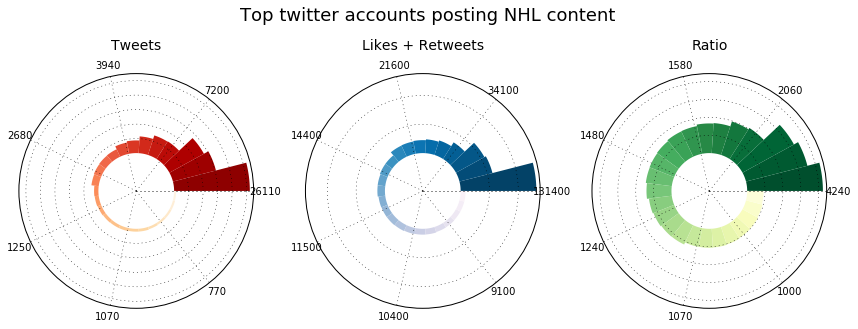

In [82]:
fig = plt.figure(figsize=(12, 8))

N = 25 # len(sorted_users['count'])

c1 = sns.color_palette("OrRd", N)
c2 = sns.color_palette("PuBu", N)
c3 = sns.color_palette("YlGn", N)




ax = plt.subplot(131, projection='polar')
x = np.linspace(0, 2*np.pi, N+1)[:-1]
y = [sorted_users['count'][i][1] for i in range(N)]
#y = np.log(y)
ax.bar(x, y, width=2*np.pi/N, color=c1[::-1], linewidth=0)

xtks = np.linspace(0, 2*np.pi, 8)
ax.set_xticks(xtks)
ax.set_xticklabels([str(round(y[int(x/np.pi/2*N)], -1)) for x in xtks[:-1]])
#ax.set_xticklabels([str(round(np.exp(y[int(x/np.pi/2*N)]), 0)) for x in xtks[:-1]])
ax.set_yticklabels([])
ax.set_ylim(-max(y)/2, max(y)*1.05)
ax.set_title('Tweets', y=1.08, fontsize=14)




ax = plt.subplot(132, projection='polar')
x = np.linspace(0, 2*np.pi, N+1)[:-1]
y = [sorted_users['influence'][i][1] for i in range(N)]
#y = np.log(y)
ax.bar(x, y, width=2*np.pi/N, color=c2[::-1], linewidth=0)

xtks = np.linspace(0, 2*np.pi, 8)
ax.set_xticks(xtks)
ax.set_xticklabels([str(round(y[int(x/np.pi/2*N)], -2)) for x in xtks[:-1]])
#ax.set_xticklabels([str(round(np.exp(y[int(x/np.pi/2*N)]), 0)) for x in xtks[:-1]])
ax.set_yticklabels([])
ax.set_ylim(-max(y)/2, max(y)*1.05)
ax.set_title('Favorites + Retweets', y=1.08, fontsize=14)




ax = plt.subplot(133, projection='polar')
x = np.linspace(0, 2*np.pi, N+1)[:-1]
y = [sorted_users['ratio'][i][1] for i in range(N)]
#y = np.log(y)
ax.bar(x, y, width=2*np.pi/N, color=c3[::-1], linewidth=0)

xtks = np.linspace(0, 2*np.pi, 8)
ax.set_xticks(xtks)
ax.set_xticklabels([str(int(round(y[int(x/np.pi/2*N)], -1))) for x in xtks[:-1]])
#ax.set_xticklabels([str(round(np.exp(y[int(x/np.pi/2*N)]), 0)) for x in xtks[:-1]])
ax.set_yticklabels([])
ax.set_ylim(-max(y)/2, max(y)*1.05)
ax.set_title('Ratio', y=1.08, fontsize=14)




plt.tight_layout()
plt.suptitle('Top twitter accounts posting NHL content', y=0.82, fontsize=18)
plt.savefig('figures/count_influence_ratio_circles.png', bbox_inches='tight', dpi=144)

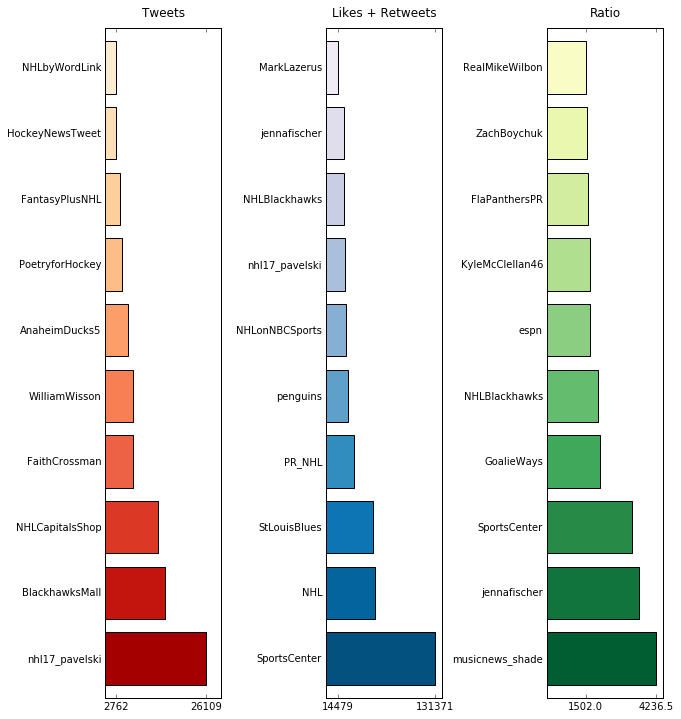

In [162]:
fig = plt.figure(figsize=(10, 12))

N = 10

c1 = sns.color_palette("OrRd", N)
c2 = sns.color_palette("PuBu", N)
c3 = sns.color_palette("YlGn", N)

ax = plt.subplot(131)
x = np.arange(0, 10, 1)
y = [sorted_users['count'][i][1] for i in range(10)]
ax.barh(x, y, color=c1[::-1])
ax.set_title('Tweets', y=1.01)
ax.set_yticks(x+0.4)
ax.set_yticklabels([sorted_users['count'][i][0] for i in range(10)])
ax.set_ylim(-0.2, 10)
ax.set_xticks([y[0], y[9]])
ax.set_xticklabels([y[0], y[9]])
plt.setp(ax.get_yticklines(), visible=False)

ax = plt.subplot(132)
x = np.arange(0, 10, 1)
y = [sorted_users['influence'][i][1] for i in range(10)]
ax.barh(x, y, color=c2[::-1])
ax.set_title('Favorites + Retweets', y=1.01)
ax.set_yticks(x+0.4)
ax.set_yticklabels([sorted_users['influence'][i][0] for i in range(10)])
ax.set_ylim(-0.2, 10)
ax.set_xticks([y[0], y[9]])
ax.set_xticklabels([y[0], y[9]])
plt.setp(ax.get_yticklines(), visible=False)

ax = plt.subplot(133)
x = np.arange(0, 10, 1)
y = [sorted_users['ratio'][i][1] for i in range(10)]
ax.barh(x, y, color=c3[::-1])
ax.set_title('Ratio', y=1.01)
ax.set_yticks(x+0.4)
ax.set_yticklabels([sorted_users['ratio'][i][0] for i in range(10)])
ax.set_ylim(-0.2, 10)
ax.set_xticks([y[0], y[9]])
ax.set_xticklabels([y[0], y[9]])
plt.setp(ax.get_yticklines(), visible=False)

plt.subplots_adjust(wspace=0.9)

plt.savefig('figures/count_influence_ratio_bar.png', bbox_inches='tight', dpi=144)

#### Most popular tweets about each player

In [133]:
pop_tweets = {}
for player in all_players:
    top_tweet = df_originals[(df_originals.search_phrase == player)].sort_values(by='influence', ascending=False).iloc[0,:]
    pop_tweets[player] = [top_tweet.text, top_tweet.favorite_count, top_tweet.retweet_count]
pop_tweets

{'Crosby': ['Sidney Crosby may be in the eye of the storm, but he can weave through Lightning. https://t.co/1BRUBt7NCR',
  4551,
  3034],
 'Forsberg': ['Ryan Johansen and Filip Forsberg fall over the boards at the same time while celebrating a goal 😂😂 \nhttps://t.co/3Su1XeRkxF',
  2145,
  1244],
 'Giroux': ['Claude Giroux is better than Sidney Cro- https://t.co/Zv7589oAiu',
  919,
  313],
 'Jagr': ['44-year-old Jaromir Jagr is returning to the Panthers after agreeing on 1-year contract. It will be his 23rd season. https://t.co/on8lEVps6E',
  5522,
  2580],
 'Kane': ['Congrats to Patrick Kane on being named a finalist for the 2016 Hart Memorial Trophy! \n\n#SHOWTIME https://t.co/CJQNVJfZNF',
  5161,
  1898],
 'Kucherov': ['Tampa Bay takes the series opener, defeating the Red Wings, 3-2. \n\nNikita Kucherov: 2 G, 1 A https://t.co/6f7a2kVsLM',
  1512,
  840],
 'Lucic': ["Lucic *very* much wants to remain in Los Angeles. Talks progressing; he indicated that they're not worlds apart.",
  42

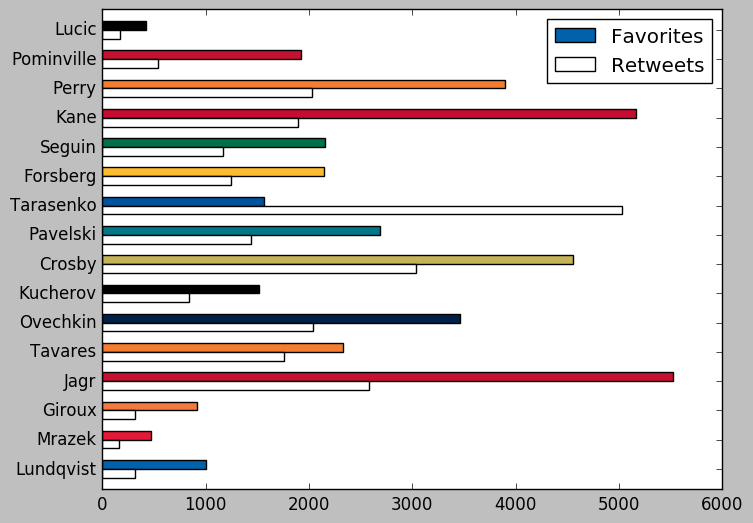

In [159]:
fig = plt.figure()
ax = fig.add_subplot(111)

colors = [colors_dict[p] for p in all_players]

x1 = np.arange(0, len(all_players), 1)
x2 = x1 - 0.3

# y1 = likes
y1 = [pop_tweets[p][1] for p in all_players]
# y2 = retweets
y2 = [pop_tweets[p][2] for p in all_players]

ax.barh(x1, y1, color=colors, height=0.3, label='Favorites')
ax.barh(x2, y2, color='white', height=0.3, label='Retweets')

ax.set_yticks(x1)
ax.set_yticklabels([p for p in all_players])
ax.set_ylim(-0.7, 15.7)
plt.legend()

plt.savefig('figures/most_influential_tweets', bbox_inches='tight', dpi=144)

plt.show();

In [160]:
pop_tweets = {}
for player in all_players:
    top_tweet = df_originals[(df_originals.search_phrase == player)].sort_values(by='favorite_count', ascending=False).iloc[0,:]
    pop_tweets[player] = [top_tweet.text, top_tweet.favorite_count, top_tweet.retweet_count]
pop_tweets

{'Crosby': ['Sidney Crosby may be in the eye of the storm, but he can weave through Lightning. https://t.co/1BRUBt7NCR',
  4551,
  3034],
 'Forsberg': ['Ryan Johansen and Filip Forsberg fall over the boards at the same time while celebrating a goal 😂😂 \nhttps://t.co/3Su1XeRkxF',
  2145,
  1244],
 'Giroux': ['Claude Giroux is better than Sidney Cro- https://t.co/Zv7589oAiu',
  919,
  313],
 'Jagr': ['44-year-old Jaromir Jagr is returning to the Panthers after agreeing on 1-year contract. It will be his 23rd season. https://t.co/on8lEVps6E',
  5522,
  2580],
 'Kane': ['Congrats to Patrick Kane on being named a finalist for the 2016 Hart Memorial Trophy! \n\n#SHOWTIME https://t.co/CJQNVJfZNF',
  5161,
  1898],
 'Kucherov': ['Tampa Bay takes the series opener, defeating the Red Wings, 3-2. \n\nNikita Kucherov: 2 G, 1 A https://t.co/6f7a2kVsLM',
  1512,
  840],
 'Lucic': ["Lucic *very* much wants to remain in Los Angeles. Talks progressing; he indicated that they're not worlds apart.",
  42

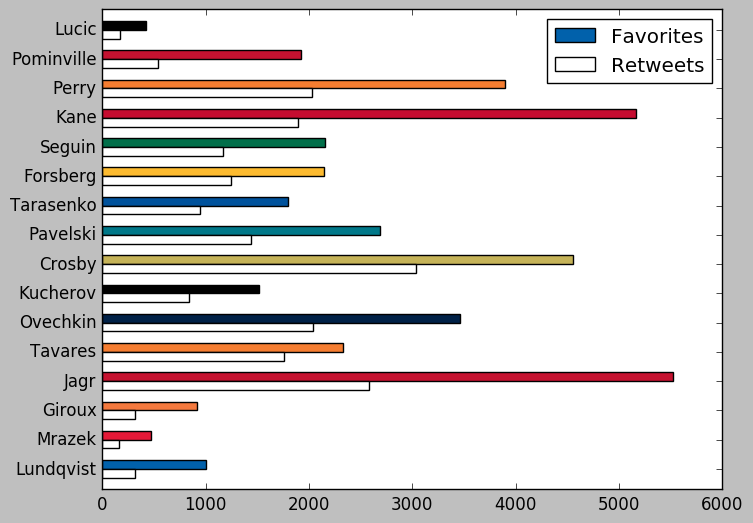

In [161]:
fig = plt.figure()
ax = fig.add_subplot(111)

colors = [colors_dict[p] for p in all_players]

x1 = np.arange(0, len(all_players), 1)
x2 = x1 - 0.3

# y1 = likes
y1 = [pop_tweets[p][1] for p in all_players]
# y2 = retweets
y2 = [pop_tweets[p][2] for p in all_players]

ax.barh(x1, y1, color=colors, height=0.3, label='Favorites')
ax.barh(x2, y2, color='white', height=0.3, label='Retweets')

ax.set_yticks(x1)
ax.set_yticklabels([p for p in all_players])
ax.set_ylim(-0.7, 15.7)
plt.legend()

plt.savefig('figures/most_favorited_tweets', bbox_inches='tight', dpi=144)

plt.show();

### Machine learning application
Try and guess average number of likes + retweets (categorically i.e. a classification problem) given the number of followers and following

In [30]:
df.columns

Index(['created_at', 'favorite_count', 'followers_count', 'friends_count',
       'retweet_count', 'screen_name', 'search_phrase', 'text', 'RT'],
      dtype='object')

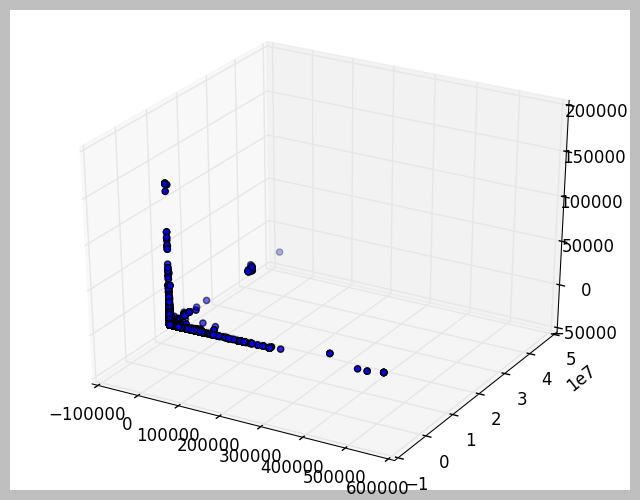

In [31]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.friends_count.values, df.followers_count.values,
            df.favorite_count.values+df.retweet_count.values)
plt.show()

This doesn't look promising ... let's split up the data into categories and re-plot with different symbols/colors instead of a third axes.

#### Make a histogram of `df.influence` = likes + retweets

In [32]:
df_originals.head(1)

created_at  favorite_count  followers_count  friends_count  \
1 2016-05-18 23:59:17               5             6381            646   

   retweet_count screen_name search_phrase  \
1              2  BWest_Trib        Crosby   

                                                text     RT  
1  OK, 1 more bit about Kunitz. I got a few ?'s a...  False

In [33]:
# Getting a warning ... not sure why
df_originals['influence'] = df_originals.iloc[:,1] + df_originals.iloc[:,4]

C:\Anaconda3\envs\py35\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [34]:
df_originals.describe()

favorite_count  followers_count  friends_count  retweet_count      RT  \
count   453641.000000    453641.000000  453641.000000  453641.000000  453641   
mean         2.319960      9467.859025    1040.066546       1.220150       0   
std         35.143598    292541.661285    5446.356428      23.254936       0   
min          0.000000         0.000000       0.000000       0.000000   False   
25%          0.000000        92.000000      78.000000       0.000000       0   
50%          0.000000       333.000000     278.000000       0.000000       0   
75%          0.000000       951.000000     848.000000       0.000000       0   
max       5522.000000  28539504.000000  505524.000000    5031.000000   False   

           influence  
count  453641.000000  
mean        3.540110  
std        55.781706  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         1.000000  
max      8102.000000

In [35]:
x = df_originals.influence.values
x_log = np.log(df_originals.influence[df_originals.influence != 0]).values

#### Plot normalized histogram and cumulative sum

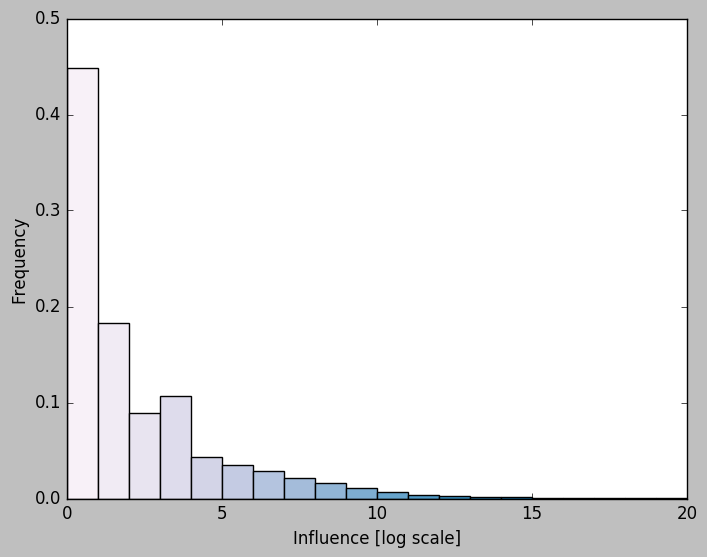

In [36]:
fig = plt.figure()

bins = 20

c2 = sns.color_palette("PuBu", bins)

ax = fig.add_subplot(111)

hist = np.histogram(x_log, bins=bins)

ax.bar(range(bins), hist[0]/sum(hist[0]), width=20/bins, color=c2)

ax.set_ylim(0.0, 0.5)
ax.set_xlabel('Influence [log scale]')

ax.set_ylabel('Frequency')
plt.show()

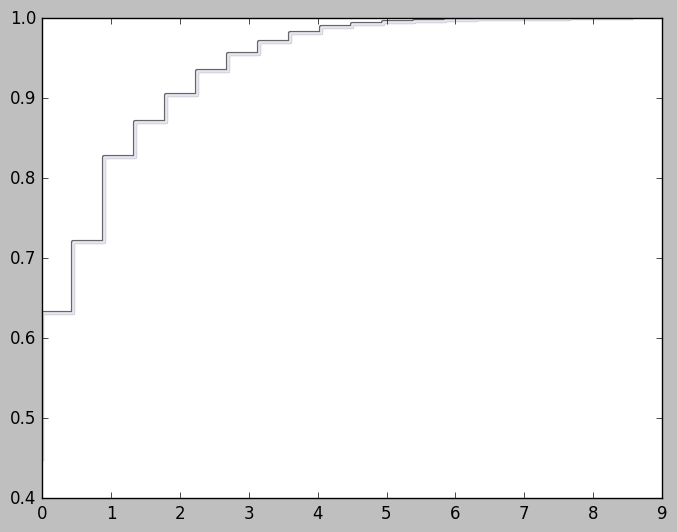

In [37]:
# Don't really trust this plot ...

fig = plt.figure()
ax = fig.add_subplot(111)

csum = np.cumsum(hist[0])
ax.step(hist[1][:-1], csum/csum.max(), color='black', lw=3, alpha=0.6)
ax.step(hist[1][:-1], csum/csum.max(), color=c2[2], lw=2)
plt.show()

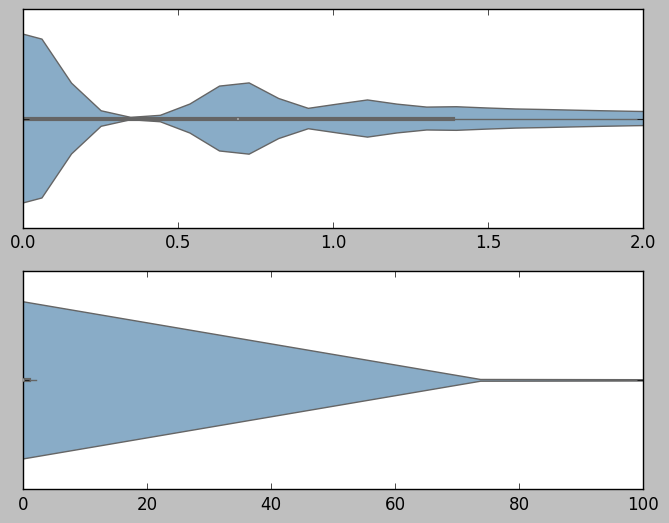

In [38]:
fig = plt.figure()

ax = fig.add_subplot(211)
ax = sns.violinplot(x_log, color=c2[9])
ax.set_xlim(0, 2)

ax = fig.add_subplot(212)
ax = ax = sns.violinplot(x, color=c2[9])
ax.set_xlim(0, 100)

plt.savefig('figures/influence_violin.png', bbox_inches='tight', dpi=144)
plt.show()

We want minimal categories. Perhaps: none (0), low (1-5), moderate(6-15), high(16-100), famous(100+)

In [39]:
influence_map = {'None': 1, 'Low': 2,
                 'Moderate': 3, 'High': 4}
                 #'Famous': np.exp(hist[1][8])}
influence_map_inv = {k: v for v, k in influence_map.items()}
influence_map_inv

{1: 'None', 2: 'Low', 3: 'Moderate', 4: 'High'}

In [40]:
def influence_category(x):
    if x == 0:
        return 'None'
    elif x <= 2:
        return 'Low'
    elif x <= 6:
        return 'Moderate'
    elif x > 6:
        return 'High'

df_originals['influence_category'] = [influence_category(x) for x in df_originals.influence]
df_originals['influence_category'] = df_originals['influence_category'].map(influence_map).astype(int)

C:\Anaconda3\envs\py35\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\envs\py35\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [41]:
# Any null values?

df_originals[df_originals.isnull().any(axis=1)]
# df_originals = df_originals.drop('influence_category')

Empty DataFrame
Columns: [created_at, favorite_count, followers_count, friends_count, retweet_count, screen_name, search_phrase, text, RT, influence, influence_category]
Index: []

In [42]:
df_originals.dtypes

created_at            datetime64[ns]
favorite_count                 int64
followers_count                int64
friends_count                  int64
retweet_count                  int64
screen_name                   object
search_phrase                 object
text                          object
RT                              bool
influence                      int64
influence_category             int32
dtype: object

In [43]:
c4 = ['blue', 'red', 'green', 'orange']

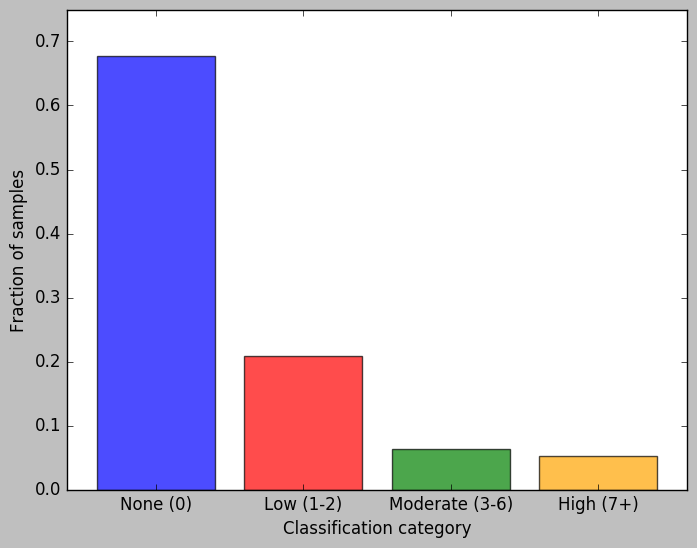

In [167]:
influence_hist = np.histogram(df_originals.influence_category.values, bins=len(np.unique(df_originals.influence_category)))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(range(len(np.unique(df_originals.influence_category))), influence_hist[0]/sum(influence_hist[0]),
        alpha=0.7, color=c4)
ax.set_xlim(-0.2, 4)
ax.set_ylim(0, 0.75)
ax.set_xticks(np.array([0, 1, 2, 3])+0.4)
ax.set_xticklabels(['None (0)', 'Low (1-2)', 'Moderate (3-6)', 'High (7+)'])
ax.set_xlabel('Classification category')
ax.set_ylabel('Fraction of samples')
plt.show()

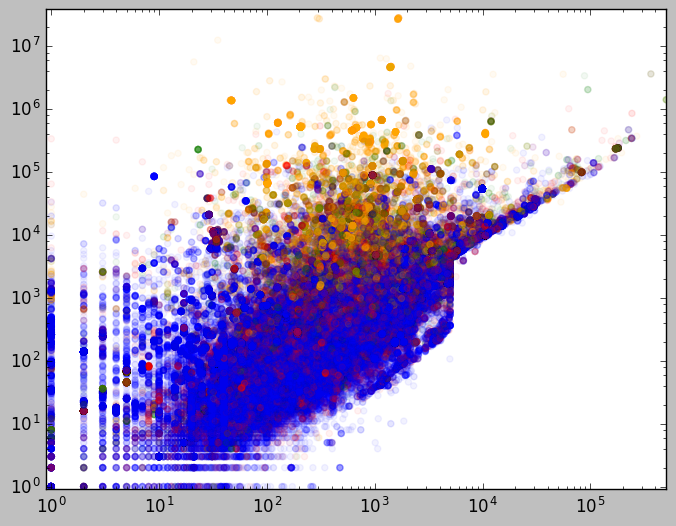

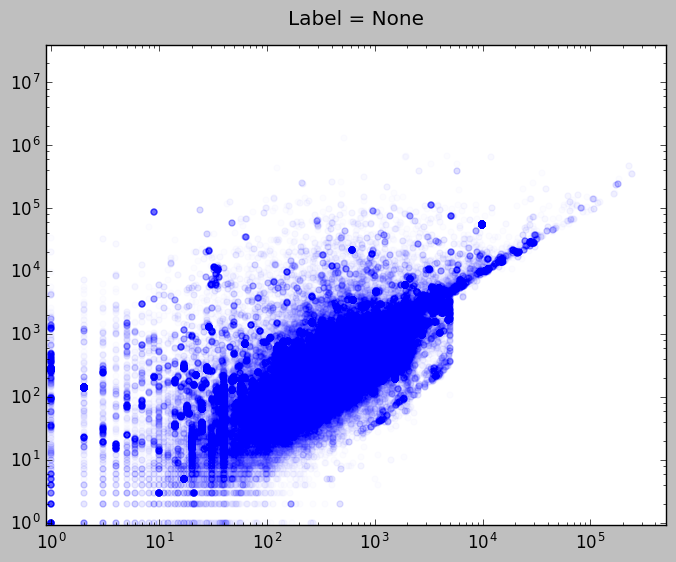

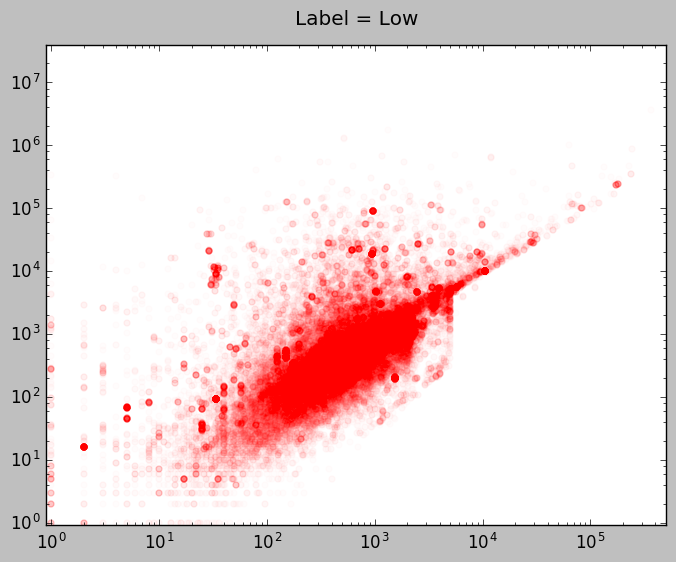

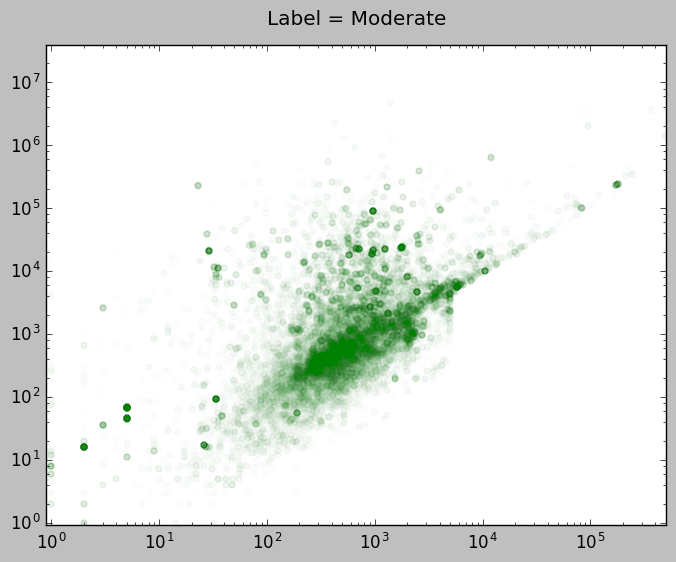

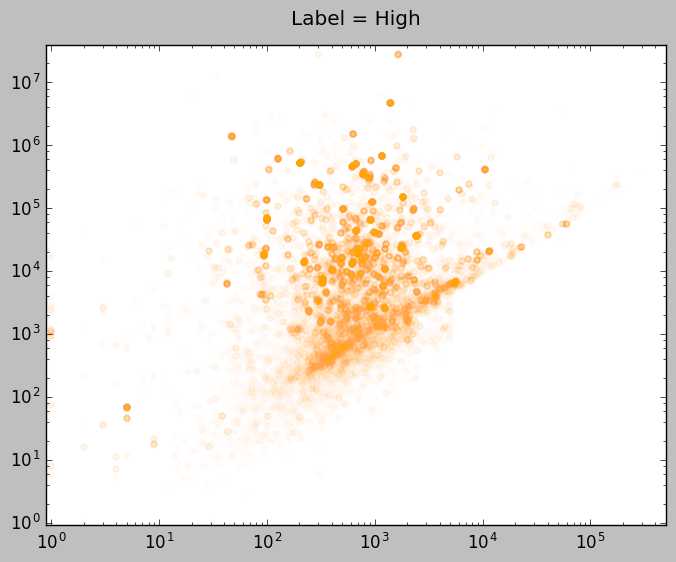

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(df_originals.friends_count.values, df_originals.followers_count.values, color=[c4[i-1] for i in df_originals.influence_category], alpha=0.05)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(0.9, df.friends_count.max())
ax.set_ylim(0.9, df.followers_count.max())
plt.show()
fig = plt.figure()

for i, y in enumerate(np.unique(df_originals.influence_category)):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(df_originals[(df_originals['influence_category'] == y)].friends_count.values,
               df_originals[(df_originals['influence_category'] == y)].followers_count.values,
               color=c4[i], alpha=0.01)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(0.9, df.friends_count.max())
    ax.set_ylim(0.9, df.followers_count.max())
    ax.set_title('Label = '+influence_map_inv[y], y=1.03)
    plt.savefig('figures/influence_categories'+str(y)+'.png', bbox_inches='tight', dpi=144)
    plt.show()

In [46]:
# x_all = np.vstack((df_originals.friends_count.values, df_originals.followers_count.values)).T

In [47]:
# from scipy import stats

# def plot_kde(ax, samples):
#     x = np.linspace(0, df.friends_count.max(), 100)
#     y = np.linspace(0, df.followers_count.max(), 100)
#     X, Y = np.meshgrid(x, y)
#     xy = np.vstack([X.ravel(), Y.ravel()])
#     # sample_stack = np.vstack((samples.T[0].ravel(), samples.T[1].ravel())).T
#     kde = stats.gaussian_kde(samples)
#     z = kde(xy).T
#     Z = np.reshape(z, X.shape)
#     ax.imshow(np.rot90(Z), cmap=plt.cm.YlOrRd,
#               extent=[-1, 1, -1, 1])

# for i, y in enumerate(np.unique(df_originals.influence_category)):
#     if i==1:
#         break

#     x_kde = np.vstack((df_originals[(df_originals['influence_category'] == y)].friends_count.values,
#                        df_originals[(df_originals['influence_category'] == y)].followers_count.values)).T
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     plot_kde(ax, np.vstack({tuple(row) for row in x_kde})[::1000])
# #     ax.scatter(df_originals[(df_originals['influence_category'] == y)].friends_count.values,
# #                df_originals[(df_originals['influence_category'] == y)].followers_count.values,
# #                color=c4[i], alpha=0.1)
#     ax.set_yscale('log')
#     ax.set_xscale('log')
#     ax.set_xlim(0.9, df.friends_count.max())
#     ax.set_ylim(0.9, df.followers_count.max())

#     plt.show()

In [48]:
# x_kde = np.vstack((df_originals[(df_originals['influence_category'] == y)].friends_count.values,
#                    df_originals[(df_originals['influence_category'] == y)].followers_count.values)).T

# x_wtf = np.vstack({tuple(row) for row in x_kde})
# print(x_kde.shape)
# print(x_wtf.shape)

### kNN classifier

In [221]:
# Get training and testing data from dataframe

from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_originals[['friends_count', 'followers_count']].values,
    df_originals['influence_category'].values,
    test_size = 0.3,
    random_state = 0)

In [222]:
# Standardize features

from sklearn.preprocessing import StandardScaler
std_sc = StandardScaler()
std_sc.fit(X_train)
X_train_std = std_sc.transform(X_train)
X_test_std = std_sc.transform(X_test)

C:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [210]:
# Adapted from Python Machine Learning book

from matplotlib.colors import ListedColormap

def plot_decision_regions(ax, X, y, classifier, l_dict, resolution=0.02, limits=[]):
    
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'orange', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    if limits:
        x1_min, x1_max, x2_min, x2_max = limits
    else:
        x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    ax.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    if limits:
        ax.set_xlim(limits[0], limits[1])
        ax.set_ylim(limits[2], limits[3])
    else:
        ax.set_xlim(xx1.min(), xx1.max())
        ax.set_ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                   alpha=0.8, c=cmap(idx),
                   marker=markers[idx], label=l_dict[cl-1])

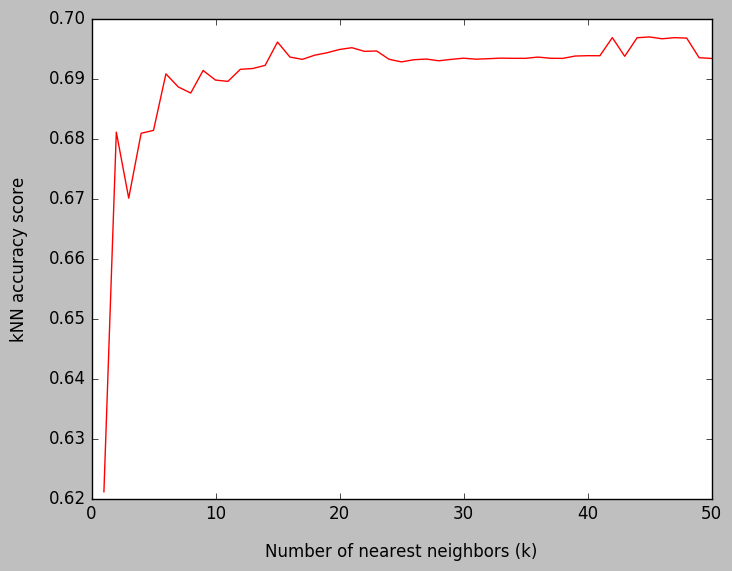

In [194]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

acc = []
N = 50
for n in range(1,N+1):
    knn = KNeighborsClassifier(n_neighbors=n, p=2, metric='minkowski')
    knn.fit(X_train_std, y_train)
    y_pred = knn.predict(X_test_std)

    acc.append(accuracy_score(y_test, y_pred))
    
plt.plot(range(1,N+1), acc, color='black')
plt.ylabel('kNN accuracy score', labelpad=15)
plt.xlabel('Number of nearest neighbors (k)', labelpad=15)
plt.savefig('figures/kNN_accuracy.png', bbox_inches='tight', dpi=144)
plt.show()

The highest accuracy seems to max out around k=20. Let's look closer at this guy.

In [198]:
knn = KNeighborsClassifier(n_neighbors=20, p=2, metric='minkowski')
knn.fit(X_train_std, y_train)
y_pred = knn.predict(X_test_std)

accuracy_score(y_test, y_pred)

0.69485674482447779

In [199]:
print('X')
print(X_train.shape)
print(X_test.shape)
print(np.vstack((X_train, X_test)).shape)

print('y')
print(y_train.shape)
print(y_test.shape)
print(np.hstack((y_train, y_test)).shape)

X
(227785, 2)
(97623, 2)
(325408, 2)
y
(227785,)
(97623,)
(325408,)


#### Only plotting 1 in 10 samples (training + test)

In [208]:
# Dictionary for labeling decision region plots
l_dict = ['None', 'Low', 'Moderate', 'High']

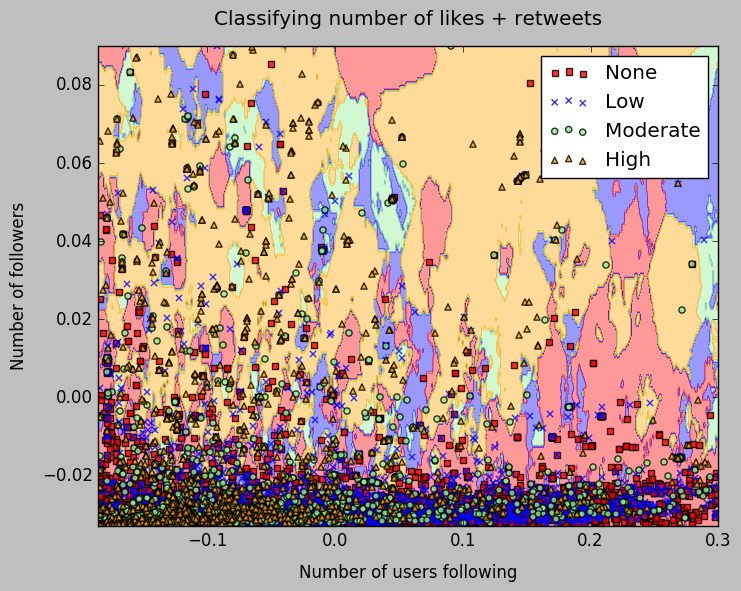

In [212]:
fig = plt.figure()
ax = fig.add_subplot(111)
limits = [-0.22, 0.3, -0.033, 0.1]
plot_decision_regions(ax,
                      np.vstack((X_train_std, X_test_std))[::10],
                      np.hstack((y_train, y_test))[::10],
                      classifier=knn,
                      l_dict = l_dict,
                      resolution=0.001, limits=limits)
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim(-0.185, limits[1])
ax.set_ylim(-0.03275, 0.09)

ax.set_xlabel('Number of users following', labelpad=10)
ax.set_ylabel('Number of followers', labelpad=10)
plt.title('Classifying number of likes + retweets', y=1.03)
plt.legend()

plt.savefig('figures/kNN_decision_regions_1.png', bbox_inches='tight', dpi=144)

plt.show()

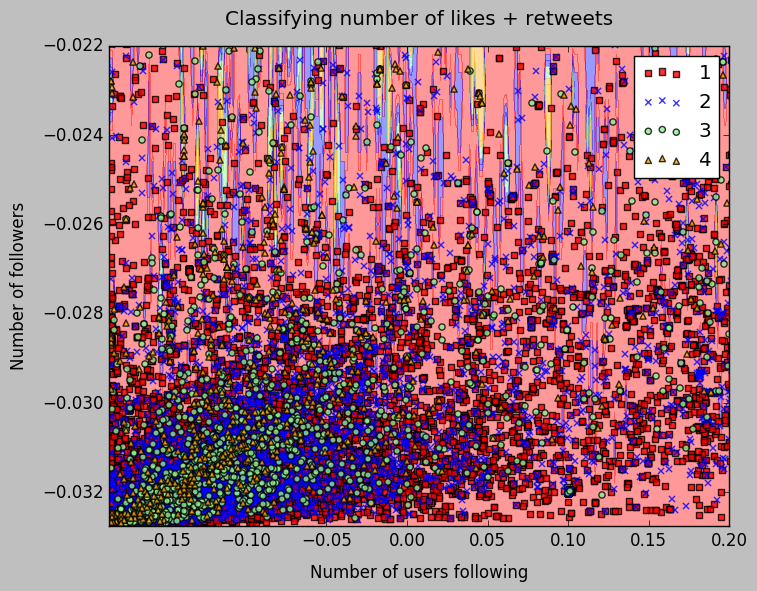

In [202]:
fig = plt.figure()
ax = fig.add_subplot(111)
plot_decision_regions(ax,
                      np.vstack((X_train_std, X_test_std))[::10],
                      np.hstack((y_train, y_test))[::10],
                      classifier=knn,
                      l_dict = l_dict,
                      resolution=0.001,
                      limits=[-0.22, 0.2, -0.033, -0.022])
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim(-0.185, 0.2)
ax.set_ylim(-0.03275, -0.022)

ax.set_xlabel('Number of users following', labelpad=10)
ax.set_ylabel('Number of followers', labelpad=10)
plt.title('Classifying number of likes + retweets', y=1.03)
plt.legend()

plt.savefig('figures/kNN_decision_regions_2.png', bbox_inches='tight', dpi=144)

plt.show()

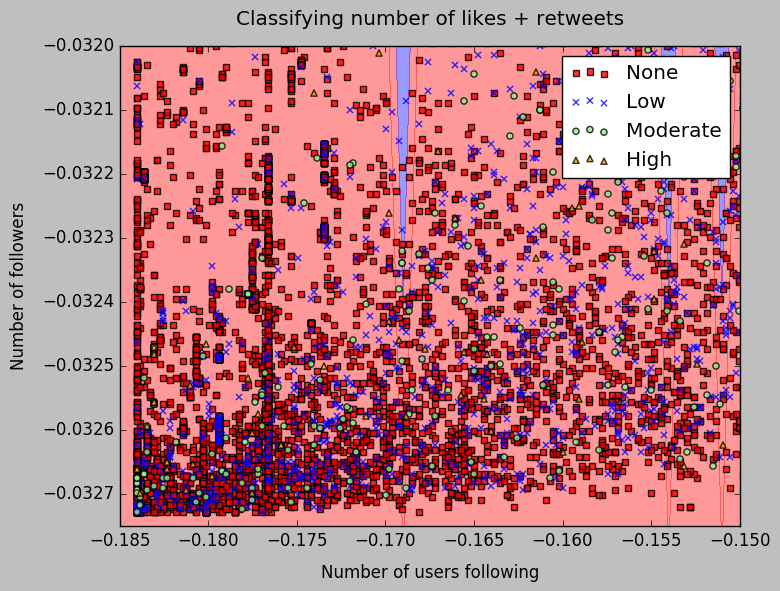

In [213]:
fig = plt.figure()
ax = fig.add_subplot(111)
plot_decision_regions(ax,
                      np.vstack((X_train_std, X_test_std))[::10],
                      np.hstack((y_train, y_test))[::10],
                      classifier=knn,
                      l_dict = l_dict,
                      resolution=0.001,
                      limits=[-0.22, 0.2, -0.033, -0.022])
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim(-0.185, -0.15)
ax.set_ylim(-0.03275, -0.032)

ax.set_xlabel('Number of users following', labelpad=10)
ax.set_ylabel('Number of followers', labelpad=10)
plt.title('Classifying number of likes + retweets', y=1.03)
plt.legend()

plt.savefig('figures/kNN_decision_regions_3.png', bbox_inches='tight', dpi=144)

plt.show()

In [204]:
from sklearn.metrics import confusion_matrix

cmat = confusion_matrix(y_test, y_pred)
cmat

array([[61099,  4462,   166,   467],
       [15497,  4128,   244,   478],
       [ 4119,  1113,   269,   583],
       [ 2036,   403,   221,  2338]])

It looks like a ton of low (1-2), moderate (2-6), and high (7+) influence tweets being classified as none (0). This is indicated by the first column.

Let's calculate the accuracy score for each category using the confusion matrix. We can get this by dividing the diagonal entries by the row sums.

In [205]:
cmat.diagonal()/cmat.sum(axis=1)

array([ 0.92302928,  0.20288003,  0.04421433,  0.46778711])

This is concerning ... we classify nearly all the 'easy ones' (none) correctly but fail big time with the rest. I'd like to try and classify the low, moderate, and high categories better even if it comes at a cost to the others. Let's see what happens to these as we change k in kNN.

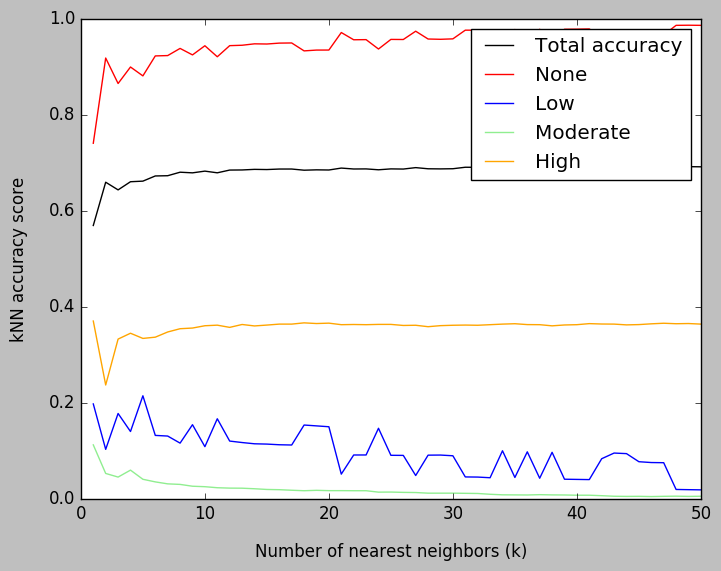

In [220]:
acc, t_acc = [], []
N = 50
for n in range(1,N+1):
    knn = KNeighborsClassifier(n_neighbors=n, p=2, metric='minkowski')
    knn.fit(X_train_std, y_train)
    y_pred = knn.predict(X_test_std)
    cmat = confusion_matrix(y_test, y_pred)
    t_acc.append(accuracy_score(y_test, y_pred))
    acc.append(cmat.diagonal()/cmat.sum(axis=1))

colors = ('red', 'blue', 'lightgreen', 'orange', 'cyan')
    
acc = np.array(acc).T
plt.plot(range(1,N+1), t_acc, label='Total accuracy', color='black')
plt.plot(range(1,N+1), acc[0], label='None', color=colors[0])
plt.plot(range(1,N+1), acc[1], label='Low', color=colors[1])
plt.plot(range(1,N+1), acc[2], label='Moderate', color=colors[2])
plt.plot(range(1,N+1), acc[3], label='High', color=colors[3])
plt.ylabel('kNN accuracy score', labelpad=15)
plt.xlabel('Number of nearest neighbors (k)', labelpad=15)
plt.legend()
plt.savefig('figures/kNN_class_accuracy.png', bbox_inches='tight', dpi=144)
plt.show()

#### Try with only one feature (followers) and see if accuracy increases

In [215]:
# Get training and testing data from dataframe

X_train, X_test, y_train, y_test = train_test_split(
    df_originals[['followers_count']].values,
    df_originals['influence_category'].values,
    test_size = 0.3,
    random_state = 0)

# Standardize features

std_sc = StandardScaler()
std_sc.fit(X_train)
X_train_std = std_sc.transform(X_train)
X_test_std = std_sc.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=20, p=2, metric='minkowski')
knn.fit(X_train_std, y_train)
y_pred = knn.predict(X_test_std)
accuracy_score(y_test, y_pred)

C:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


0.68461325712178478

In [219]:
acc = []
N = 50
for n in range(1,N+1):
    knn = KNeighborsClassifier(n_neighbors=n, p=2, metric='minkowski')
    knn.fit(X_train_std, y_train)
    y_pred = knn.predict(X_test_std)
    cmat = confusion_matrix(y_test, y_pred)
    t_acc.append(accuracy_score(y_test, y_pred))
    acc.append(cmat.diagonal()/cmat.sum(axis=1))

colors = ('red', 'blue', 'lightgreen', 'orange', 'cyan')
    
acc = np.array(acc).T
plt.plot(range(1,N+1), t_acc, label='Total accuracy', color='black')
plt.plot(range(1,N+1), acc[0], label='None')
plt.plot(range(1,N+1), acc[1], label='Low')
plt.plot(range(1,N+1), acc[2], label='Moderate')
plt.plot(range(1,N+1), acc[3], label='High')
plt.ylabel('kNN accuracy score', labelpad=15)
plt.xlabel('Number of nearest neighbors (k)', labelpad=15)
plt.legend(loc='best')
plt.savefig('figures/kNN_class_accuracy_1_feature_followers.png', bbox_inches='tight', dpi=144)
plt.show()

ValueError: setting an array element with a sequence.

With one feature we can plot y vs x, what does this look like?

In [117]:
X_train

array([[  131],
       [15977],
       [ 1609],
       ..., 
       [ 2209],
       [   91],
       [ 5088]], dtype=int64)

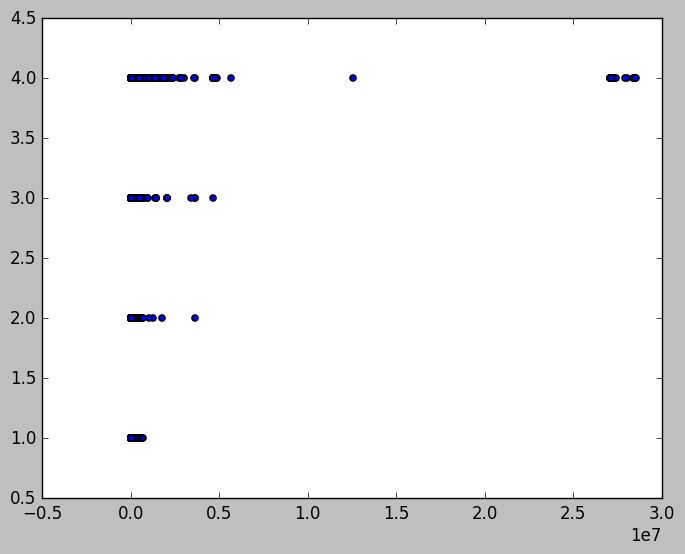

In [218]:
plt.scatter(X_train.T, y_train)
plt.show()

What if we treat this as a regression problem instead.

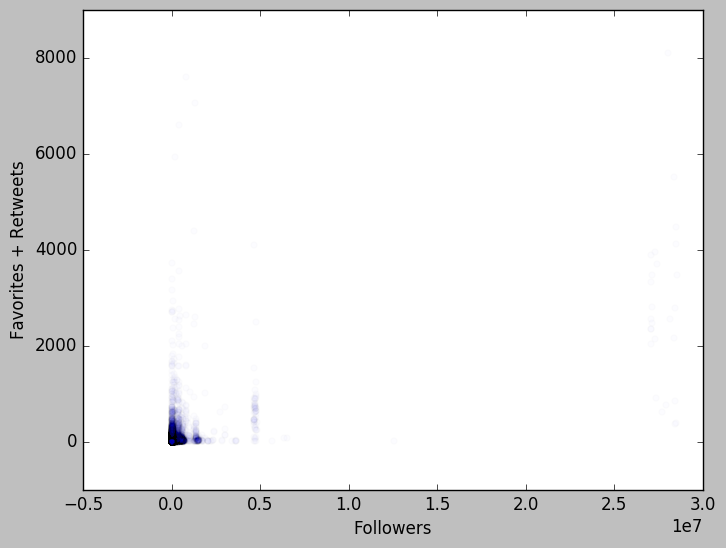

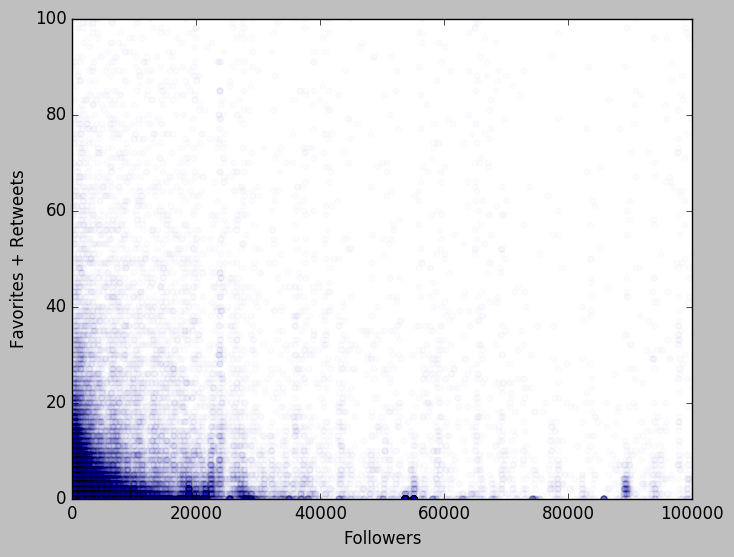

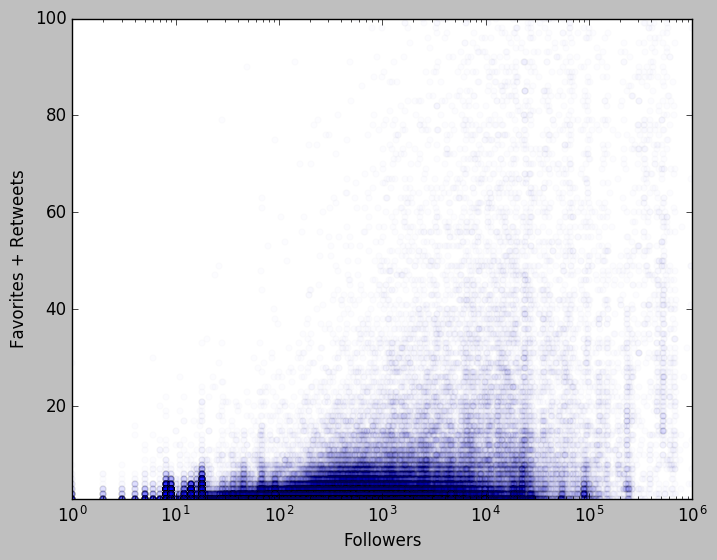

In [217]:
plt.scatter(df_originals.followers_count.values, df_originals.influence.values, alpha=0.03)
plt.xlabel('Followers')
plt.ylabel('Favorites + Retweets')
plt.xlim(0,100000)
plt.ylim(0,100)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(df_originals.followers_count.values, df_originals.influence.values, alpha=0.03)
ax.set_xlabel('Followers')
ax.set_ylabel('Favorites + Retweets')
ax.set_xscale('log')
# ax.set_yscale('log')
plt.xlim(1,1000000)
plt.ylim(1,100)
plt.show()